In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import randint 
import time
import json
import math
import re
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, export_graphviz, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV, StratifiedShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer, classification_report, RocCurveDisplay
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from imblearn.over_sampling import SMOTE, RandomOverSampler, SMOTEN, SMOTENC, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.feature_extraction.text import CountVectorizer
from xgboost import XGBClassifier
from itertools import product
from scipy.stats import randint
from sklearn import tree
from IPython.display import Image
import pydotplus
import graphviz

SEED = 42

# ***Data Overview and Exploration***

## Data Overview

In [2]:
data = pd.read_csv('MMSA_2021.csv')

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 227792 entries, 0 to 227791
Columns: 152 entries, DISPCODE to MMSANAME
dtypes: float64(151), object(1)
memory usage: 264.2+ MB


In [4]:
data.head()

,DISPCODE,STATERE1,CELPHON1,LADULT1,COLGSEX,LANDSEX,RESPSLCT,SAFETIME,CADULT1,CELLSEX,...,_FRTLT1A,_VEGLT1A,_FRT16A,_VEG23A,_FRUITE1,_VEGETE1,_MMSA,_MMSAWT,SEQNO,MMSANAME
0,1200.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,...,2.0,1.0,1.0,1.0,5.397605e-79,5.397605e-79,10100.0,90.030265,2.021000e+09,"b'Aberdeen, SD, Micropolitan Statistical Area'"
1,1200.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,...,2.0,1.0,1.0,1.0,5.397605e-79,5.397605e-79,10100.0,29.643176,2.021000e+09,"b'Aberdeen, SD, Micropolitan Statistical Area'"
2,1200.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,2.0,...,1.0,1.0,1.0,1.0,5.397605e-79,5.397605e-79,10100.0,37.000680,2.021000e+09,"b'Aberdeen, SD, Micropolitan Statistical Area'"
3,1200.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,5.397605e-79,5.397605e-79,10100.0,49.702755,2.021000e+09,"b'Aberdeen, SD, Micropolitan Statistical Area'"
4,1200.0,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,2.0,...,1.0,1.0,1.0,1.0,5.397605e-79,5.397605e-79,10100.0,15.396983,2.021000e+09,"b'Aberdeen, SD, Micropolitan Statistical Area'"


In [5]:
# Some columns have many null values
isna_data = data.isna().sum()
for column, count in isna_data.items():
    print(f"{column}: {count}")

DISPCODE: 0
STATERE1: 172268
CELPHON1: 172268
LADULT1: 172268
COLGSEX: 227774
LANDSEX: 204447
RESPSLCT: 196968
SAFETIME: 55524
CADULT1: 55524
CELLSEX: 55525
HHADULT: 55525
SEXVAR: 0
GENHLTH: 2
PHYSHLTH: 2
MENTHLTH: 0
POORHLTH: 104941
PRIMINSR: 1
PERSDOC3: 0
MEDCOST1: 1
CHECKUP1: 0
EXERANY2: 0
BPHIGH6: 0
BPMEDS: 143010
CHOLCHK3: 0
TOLDHI3: 29849
CHOLMED3: 30130
CVDINFR4: 0
CVDCRHD4: 0
CVDSTRK3: 0
ASTHMA3: 0
ASTHNOW: 195581
CHCSCNCR: 0
CHCOCNCR: 0
CHCCOPD3: 0
ADDEPEV3: 0
CHCKDNY2: 0
DIABETE4: 0
DIABAGE3: 199821
HAVARTH5: 0
ARTHEXER: 158813
ARTHEDU: 158813
LMTJOIN3: 158813
ARTHDIS2: 158813
JOINPAI2: 158813
MARITAL: 1
EDUCA: 0
RENTHOM1: 1
NUMHHOL3: 172269
NUMPHON3: 211707
CPDEMO1B: 170
VETERAN3: 949
EMPLOY1: 2047
CHILDREN: 3540
INCOME3: 5154
PREGNANT: 182883
WEIGHT2: 6747
HEIGHT3: 7408
DEAF: 8316
BLIND: 8973
DECIDE: 9547
DIFFWALK: 10201
DIFFDRES: 10646
DIFFALON: 11222
SMOKE100: 12001
SMOKDAY2: 145458
USENOW3: 12408
ECIGNOW1: 13013
ALCDAY5: 13868
AVEDRNK3: 113057
DRNK3GE5: 113425
MAXDRNKS: 

In [6]:
# If we were to drop all null values, the data would have no records left
data.dropna().shape

(0, 152)

## Hand-pick Variables
Select some interesting columns from the dataset.

#### Columns

In [7]:
columns = [
    # === List with all meaningful columns ===
    [
        # Sec 1 Health Status
        '_RFHLTH',

        # Sec 2 Healthy Days
        '_PHYS14D',
        '_MENT14D',

        # Sec 3 Health Care Access
        '_HLTHPLN',
        '_HCVU652',

        # Sec 4 Exercise
        '_TOTINDA',

        # Sec 5 Hypertension Awareness
        '_RFHYPE6',

        # Sec 6 Cholesterol Awareness
        '_CHOLCH3',
        '_RFCHOL3',

        # Sec 7 Chronic Health Conditions
        '_MICHD',

        # Sec 8 Arthritis
        '_DRDXAR3',
        '_LMTACT3',
        '_LMTWRK3',

        # Sec 11 Tobacco Use
        '_SMOKER3',
        '_RFSMOK3',
        '_CURECI1',

        # Sec 12 Alcohol Consumption
        'DRNKANY5',
        'ALCDAY5',
        '_RFBING5',
        '_DRNKWK1',
        '_RFDRHV7',

        # Sec 14 HIV/AIDS
        '_AIDTST4',

        # Sec 15 Fruits & Vegetables
        'FTJUDA2_',
        'FRUTDA2_',
        'GRENDA1_',
        'FRNCHDA_',
        'POTADA1_',
        'VEGEDA2_',
        '_FRUTSU1',
        '_VEGESU1',
        '_FRTLT1A',
        '_VEGLT1A',
        
        # Sec 9 Demographics
        '_INCOMG1',
        '_EDUCAG',
        'CHILDREN',
        '_RFBMI5',
        '_BMI5CAT',
        '_BMI5',
        'WTKG3',
        'HEIGHT3',
        '_AGE_G',
        '_AGE80',
        '_AGE65YR',
        '_AGEG5YR',
        '_SEX',
        '_RACEPRV',
        '_RACEGR3',
        '_RACEG21',
        '_RACE',
        '_HISPANC',
        '_MRACE1',
        '_PRACE1'
    ],

    # === 1st subset of all the meaningful columns === 
    [
        # Sec 1 Health Status
        '_RFHLTH',

        # Sec 2 Healthy Days
        '_PHYS14D',
        '_MENT14D',

        # Sec 3 Health Care Access
        '_HLTHPLN',
        '_HCVU652',

        # Sec 4 Exercise
        '_TOTINDA',

        # Sec 5 Hypertension Awareness
        '_RFHYPE6',

        # Sec 6 Cholesterol Awareness
        '_CHOLCH3',
        '_RFCHOL3',

        # Sec 7 Chronic Health Conditions
        '_MICHD',

        # Sec 8 Arthritis

        # Sec 11 Tobacco Use
        '_SMOKER3',

        # Sec 12 Alcohol Consumption
        '_RFBING5',
        '_RFDRHV7',

        # Sec 14 HIV/AIDS
        '_AIDTST4',

        # Sec 15 Fruits & Vegetables
        '_FRUTSU1',
        '_VEGESU1',
        
        # Sec 9 Demographics
        '_INCOMG1',
        '_EDUCAG',
        '_RFBMI5',
        '_BMI5CAT',
        '_AGE_G',
        '_SEX',
        '_RACE'
    ],


    # === 2nd subset of all the meaningul columns ===
    [
        # Sec 1 Health Status
        '_RFHLTH',

        # Sec 2 Healthy Days
        '_PHYS14D',
        '_MENT14D',

        # Sec 3 Health Care Access
        '_HLTHPLN',
        '_HCVU652',

        # Sec 4 Exercise
        '_TOTINDA',

        # Sec 5 Hypertension Awareness
        '_RFHYPE6',

        # Sec 6 Cholesterol Awareness
        '_CHOLCH3',
        '_RFCHOL3',

        # Sec 7 Chronic Health Conditions
        '_MICHD',

        # Sec 8 Arthritis
        

        # Sec 11 Tobacco Use
        '_SMOKER3',

        # Sec 12 Alcohol Consumption
        '_RFBING5',
        '_RFDRHV7',

        # Sec 14 HIV/AIDS
        '_AIDTST4',

        # Sec 15 Fruits & Vegetables
        '_FRTLT1A',
        '_VEGLT1A',
        
        # Sec 9 Demographics
        '_INCOMG1',
        '_EDUCAG',
        '_RFBMI5',
        '_BMI5CAT',
        '_AGE_G',
        '_SEX',
        '_RACE'
    ]
]

#### Categorical and Continuous Columns
We can use the one hot encoder to properly encode the values of each categorical variable that exhibits no apparent order.

In [8]:
"""

1: For categorical
2: For continuous

"""

cat_con_variables = {
    # Sec 1 Health Status
    '_RFHLTH': 1,

    # Sec 2 Healthy Days
    '_PHYS14D': 1,
    '_MENT14D': 1,

    # Sec 3 Health Care Access
    '_HLTHPLN': 1,
    '_HCVU652': 1,

    # Sec 4 Exercise
    '_TOTINDA': 1,

    # Sec 5 Hypertension Awareness
    '_RFHYPE6': 1,

    # Sec 6 Cholesterol Awareness
    '_CHOLCH3': 1,
    '_RFCHOL3': 1,

    # Sec 7 Chronic Health Conditions
    '_MICHD': 1,

    # Sec 8 Arthritis
    '_DRDXAR3': 1,
    '_LMTACT3': 1,
    '_LMTWRK3': 1,

    # Sec 11 Tobacco Use
    '_SMOKER3': 1,
    '_RFSMOK3': 1,
    '_CURECI1': 1,

    # Sec 12 Alcohol Consumption
    'DRNKANY5': 1,
    'ALCDAY5': 2,
    '_RFBING5': 1,
    '_DRNKWK1': 2,
    '_RFDRHV7': 1,

    # Sec 14 HIV/AIDS
    '_AIDTST4': 1,

    # Sec 15 Fruits & Vegetables
    'FTJUDA2_': 2,
    'FRUTDA2_': 2,
    'GRENDA1_': 2,
    'FRNCHDA_': 2,
    'POTADA1_': 2,
    'VEGEDA2_': 2,
    '_FRUTSU1': 2,
    '_VEGESU1': 2,
    '_FRTLT1A': 1,
    '_VEGLT1A': 1,
    
    # Sec 9 Demographics
    '_INCOMG1': 1,
    '_EDUCAG': 1,
    'CHILDREN': 1,
    '_RFBMI5': 1,
    '_BMI5CAT': 1,
    '_BMI5': 2,
    'WTKG3': 2,
    'HEIGHT3': 2,
    
    # === The age variables can remain the same because their values represent a natural ordering ===
    '_AGE_G': 1,
    '_AGE80': 1,
    '_AGE65YR': 1,
    '_AGEG5YR': 1,
    
    '_SEX': 1,
    '_RACEPRV': 1,
    '_RACEGR3': 1,
    '_RACEG21': 1,
    '_RACE': 1,
    '_HISPANC': 1,
    '_MRACE1': 1,
    '_PRACE1': 1
}

#### Column Values that are Irrelevant
Some columns/variables have values, such as "Dont Know/Not Sure", that are irrelevant to the analysis. These values are included in data mining methods but can be ignored in NLP mehtods. NLP methods handle text sequences of varying forms.

In [9]:
irrel_col_values = {
    # Sec 1 Health Status
    '_RFHLTH': 9,

    # Sec 2 Healthy Days
    '_PHYS14D': 9,
    '_MENT14D': 9,

    # Sec 3 Health Care Access
    '_HLTHPLN': 9,
    '_HCVU652': 9,

    # Sec 4 Exercise
    '_TOTINDA': 9,

    # Sec 5 Hypertension Awareness
    '_RFHYPE6': 9,

    # Sec 6 Cholesterol Awareness
    '_CHOLCH3': 9,
    '_RFCHOL3': 9,

    # Sec 7 Chronic Health Conditions

    # Sec 8 Arthritis
    '_LMTACT3': 9,
    '_LMTWRK3': 9,

    # Sec 11 Tobacco Use
    '_SMOKER3': 9,
    '_RFSMOK3': 9,
    '_CURECI1': 9,

    # Sec 12 Alcohol Consumption
    'DRNKANY5': 9,
    'ALCDAY5': 900,
    '_RFBING5': 9,
    '_DRNKWK1': 99900,
    '_RFDRHV7': 9,

    # Sec 14 HIV/AIDS
    '_AIDTST4': 9,

    # Sec 15 Fruits & Vegetables
    '_FRTLT1A': 9,
    '_VEGLT1A': 9,
    
    # Sec 9 Demographics
    '_INCOMG1': 9,
    '_EDUCAG': 9,
    'CHILDREN': 9,
    '_RFBMI5': 9,
    '_AGE65YR': 3,
    '_AGEG5YR': 14,
    '_RACEGR3': 9,
    '_RACEG21': 9,
    '_RACE': 9,
    '_HISPANC': 9,
    '_MRACE1': [77,99],
    '_PRACE1': [77, 99]
}

In [10]:
for column, values in irrel_col_values.items():
    if isinstance(values, int):  
        num_rows = len(data[data[column] == values])
        print(f"Number of rows with value {values} in column '{column}': {num_rows}")
    elif isinstance(values, list):  
        num_rows = len(data[data[column].isin(values)])
        print(f"Number of rows with values in {values} in column '{column}': {num_rows}")

# Calculating the size of the dataset after removing rows with specified values
filtered_data = data.copy() 
for column, values in irrel_col_values.items():
    if isinstance(values, int):  
        filtered_data = filtered_data[filtered_data[column] != values]
    elif isinstance(values, list):  
        filtered_data = filtered_data[~filtered_data[column].isin(values)]

# Calculate the size of the filtered dataset
filtered_size = filtered_data.shape[0]
print(f"Size of the dataset after removing rows with specified values: {filtered_size}")

Number of rows with value 9 in column '_RFHLTH': 601
Number of rows with value 9 in column '_PHYS14D': 4691
Number of rows with value 9 in column '_MENT14D': 4011
Number of rows with value 9 in column '_HLTHPLN': 9341
Number of rows with value 9 in column '_HCVU652': 83992
Number of rows with value 9 in column '_TOTINDA': 454
Number of rows with value 9 in column '_RFHYPE6': 1031
Number of rows with value 9 in column '_CHOLCH3': 15155
Number of rows with value 9 in column '_RFCHOL3': 1639
Number of rows with value 9 in column '_LMTACT3': 712
Number of rows with value 9 in column '_LMTWRK3': 1664
Number of rows with value 9 in column '_SMOKER3': 14005
Number of rows with value 9 in column '_RFSMOK3': 14005
Number of rows with value 9 in column '_CURECI1': 13478
Number of rows with value 9 in column 'DRNKANY5': 15146
Number of rows with value 900 in column 'ALCDAY5': 0
Number of rows with value 9 in column '_RFBING5': 19641
Number of rows with value 99900 in column '_DRNKWK1': 19412
Numb

Some columns described in the 2021 SMART City and Country CodeBook are derived from other columns in the dataset.

- DROCDY3_ Calculated variable for drink-occasions-per-day. DROCDY3_ is derived from ALCDAY5 by dividing the ALCDAY5 variable by 7 days per week or 30 days per month.

- _CHLDCNT Calculated variable for number of children in household. _CHLDCNT is derived from CHILDREN.

- HTM4 Calculated variable for reported height in meters. HTM4 is derived from the variable HTIN4 by multiplying HTIN4 by 2.54 cm per in and dividing by 100 cm per meter. HTM4 is derived from HEIGHT2 metric values by dividing by 100.

- HTIN4 Calculated variable for reported height in inches. HTIN4 is derived from HEIGHT3. HTIN4 is calculated by adding the foot portion of HEIGHT3 multiplied by 12, to the inch portion. 

## Candidate Dataframe Creation

In [11]:
# Check if the columns selected earlier exist in the dataset
for col in columns[0]:
    if col in data.columns:
        print(col)
    else:
        print(f'{col} does not exist')

_RFHLTH
_PHYS14D
_MENT14D
_HLTHPLN
_HCVU652
_TOTINDA
_RFHYPE6
_CHOLCH3
_RFCHOL3
_MICHD
_DRDXAR3
_LMTACT3
_LMTWRK3
_SMOKER3
_RFSMOK3
_CURECI1
DRNKANY5
ALCDAY5
_RFBING5
_DRNKWK1
_RFDRHV7
_AIDTST4
FTJUDA2_
FRUTDA2_
GRENDA1_
FRNCHDA_
POTADA1_
VEGEDA2_
_FRUTSU1
_VEGESU1
_FRTLT1A
_VEGLT1A
_INCOMG1
_EDUCAG
CHILDREN
_RFBMI5
_BMI5CAT
_BMI5
WTKG3
HEIGHT3
_AGE_G
_AGE80
_AGE65YR
_AGEG5YR
_SEX
_RACEPRV
_RACEGR3
_RACEG21
_RACE
_HISPANC
_MRACE1
_PRACE1


In [12]:
# How many null values each selected column has
isna_data = data[columns[0]].isna().sum()
for column, count in isna_data.items():
    print(f"{column}: {count}")

_RFHLTH: 0
_PHYS14D: 0
_MENT14D: 0
_HLTHPLN: 0
_HCVU652: 0
_TOTINDA: 0
_RFHYPE6: 0
_CHOLCH3: 0
_RFCHOL3: 29981
_MICHD: 2308
_DRDXAR3: 1480
_LMTACT3: 1480
_LMTWRK3: 1480
_SMOKER3: 0
_RFSMOK3: 0
_CURECI1: 0
DRNKANY5: 0
ALCDAY5: 13868
_RFBING5: 0
_DRNKWK1: 0
_RFDRHV7: 0
_AIDTST4: 17092
FTJUDA2_: 24654
FRUTDA2_: 24097
GRENDA1_: 24449
FRNCHDA_: 24886
POTADA1_: 26756
VEGEDA2_: 26817
_FRUTSU1: 27859
_VEGESU1: 32613
_FRTLT1A: 0
_VEGLT1A: 0
_INCOMG1: 0
_EDUCAG: 0
CHILDREN: 3540
_RFBMI5: 0
_BMI5CAT: 26341
_BMI5: 26341
WTKG3: 22711
HEIGHT3: 7408
_AGE_G: 0
_AGE80: 0
_AGE65YR: 0
_AGEG5YR: 0
_SEX: 0
_RACEPRV: 0
_RACEGR3: 0
_RACEG21: 0
_RACE: 0
_HISPANC: 0
_MRACE1: 0
_PRACE1: 0


In [13]:
# Create dataframes based on the selected columns
# Question: Should we drop the rows with null values?
dataframes = [
    data[columns[0]].dropna().copy(),
    data[columns[1]].dropna().copy(),
    data[columns[2]].dropna().copy(),
]

In [14]:
object_cols = []
for col, cat_con_var in cat_con_variables.items():
    if cat_con_var == 1:
        object_cols.append(col)

print(f'Categorical Columns: \n{object_cols}')

Categorical Columns: 
['_RFHLTH', '_PHYS14D', '_MENT14D', '_HLTHPLN', '_HCVU652', '_TOTINDA', '_RFHYPE6', '_CHOLCH3', '_RFCHOL3', '_MICHD', '_DRDXAR3', '_LMTACT3', '_LMTWRK3', '_SMOKER3', '_RFSMOK3', '_CURECI1', 'DRNKANY5', '_RFBING5', '_RFDRHV7', '_AIDTST4', '_FRTLT1A', '_VEGLT1A', '_INCOMG1', '_EDUCAG', 'CHILDREN', '_RFBMI5', '_BMI5CAT', '_AGE_G', '_AGE80', '_AGE65YR', '_AGEG5YR', '_SEX', '_RACEPRV', '_RACEGR3', '_RACEG21', '_RACE', '_HISPANC', '_MRACE1', '_PRACE1']


In [15]:
for dataframe in dataframes:
    dataframe['_MICHD'] = dataframe['_MICHD'].replace({1.0: 1, 2.0: 2})
    dataframe['_MICHD'] = dataframe['_MICHD'].astype('int64')

    # Convert categorical columns to integers
    for column, col_type in cat_con_variables.items():
        if col_type == 1 and (column in dataframe.columns):  # Check if the column is categorical
            dataframe[column] = dataframe[column].astype('int64')

    # Use this if you want to utilize the one hot encoder
    # The one hot encoder will create sub-variables for each distinct value of a variable
    #dataframe = pd.get_dummies(dataframe, columns=object_cols)

In [16]:
dataframes[0]['_MICHD'].value_counts()

_MICHD
2    141513
1     12410
Name: count, dtype: int64

In [17]:
dataframes[0].shape

(153923, 52)

In [18]:
# Print the total number of duplicates for one of the categories of variable "_MICHD"
dataframes[2][dataframes[2]['_MICHD'] == 2].duplicated().sum()

32930

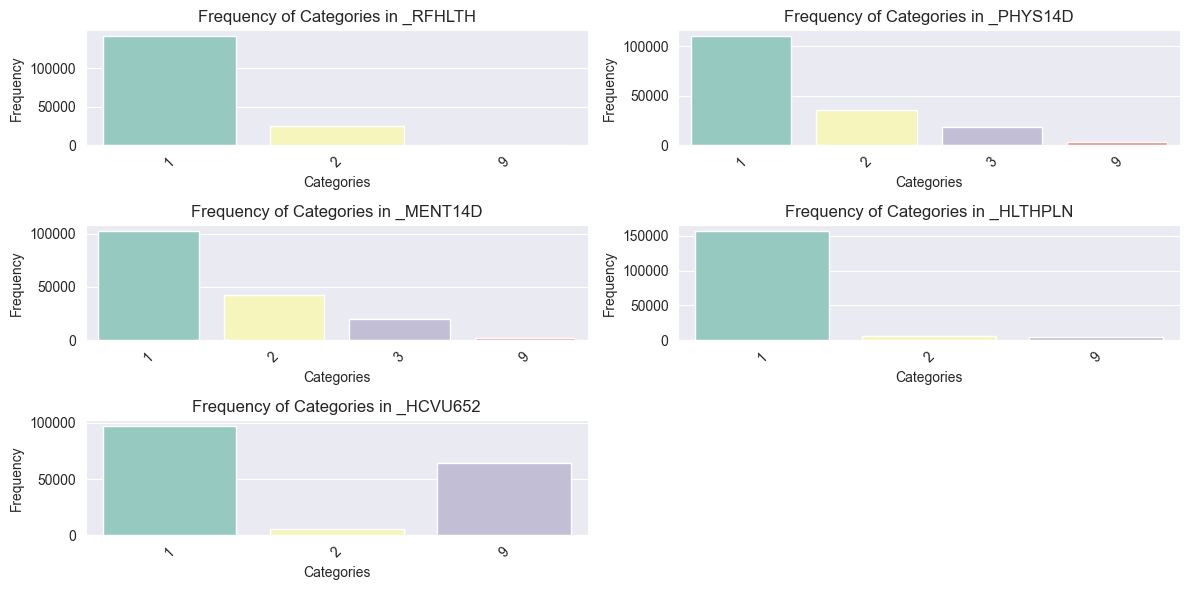

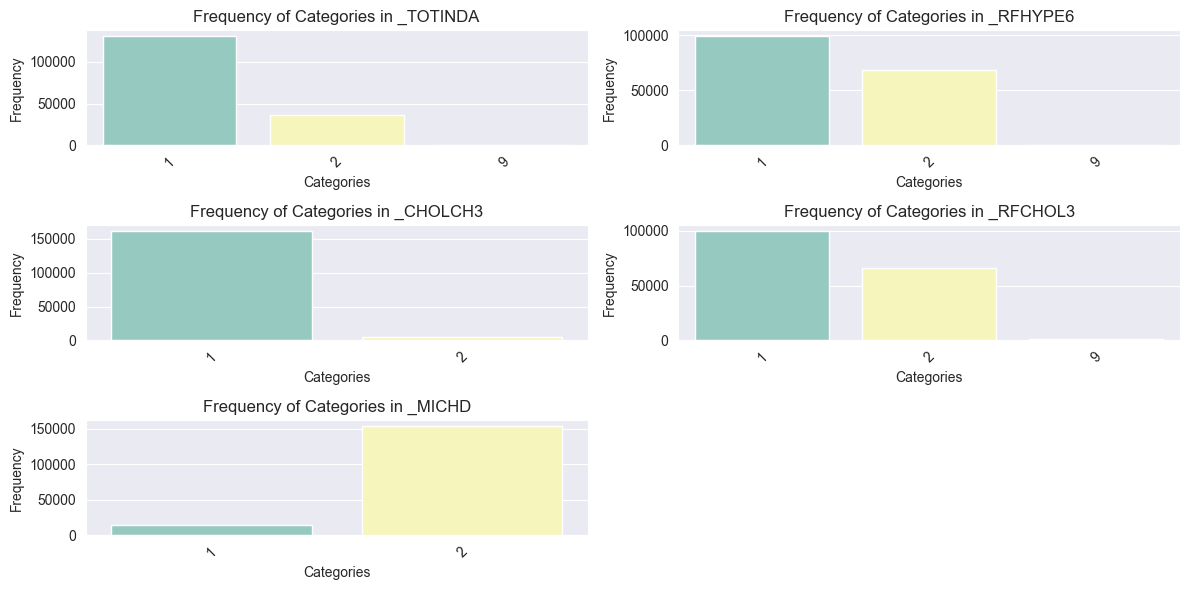

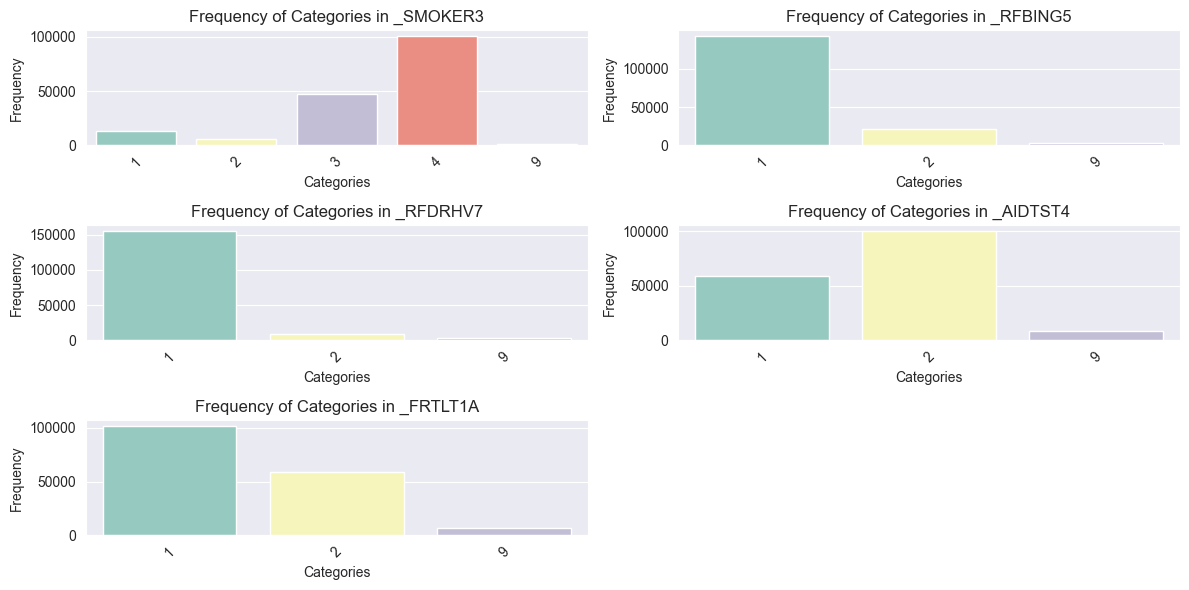

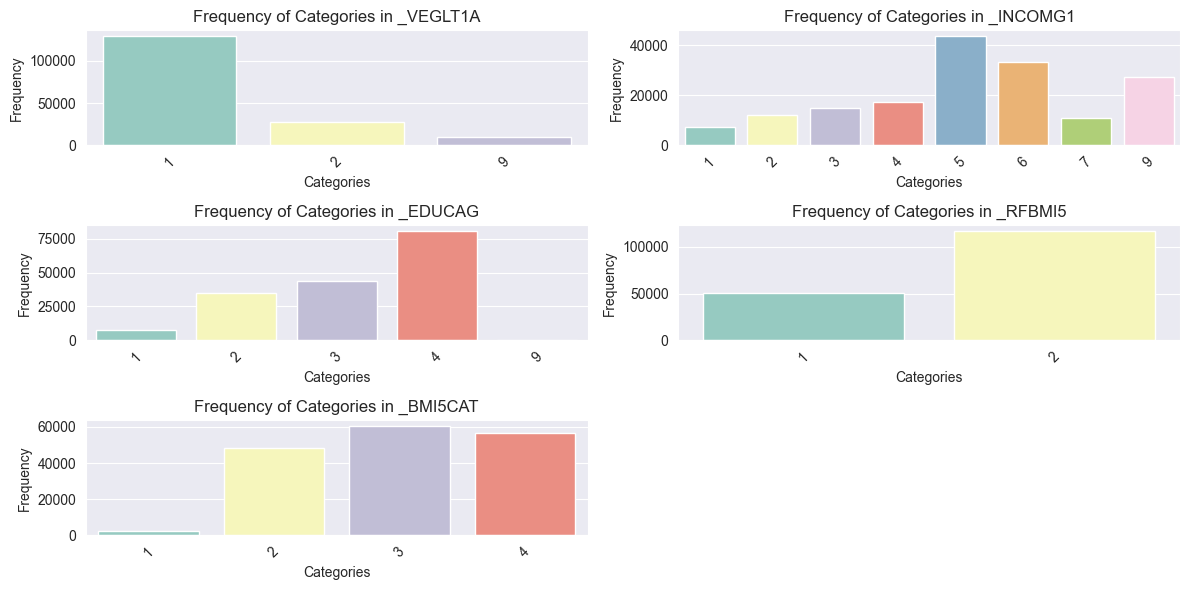

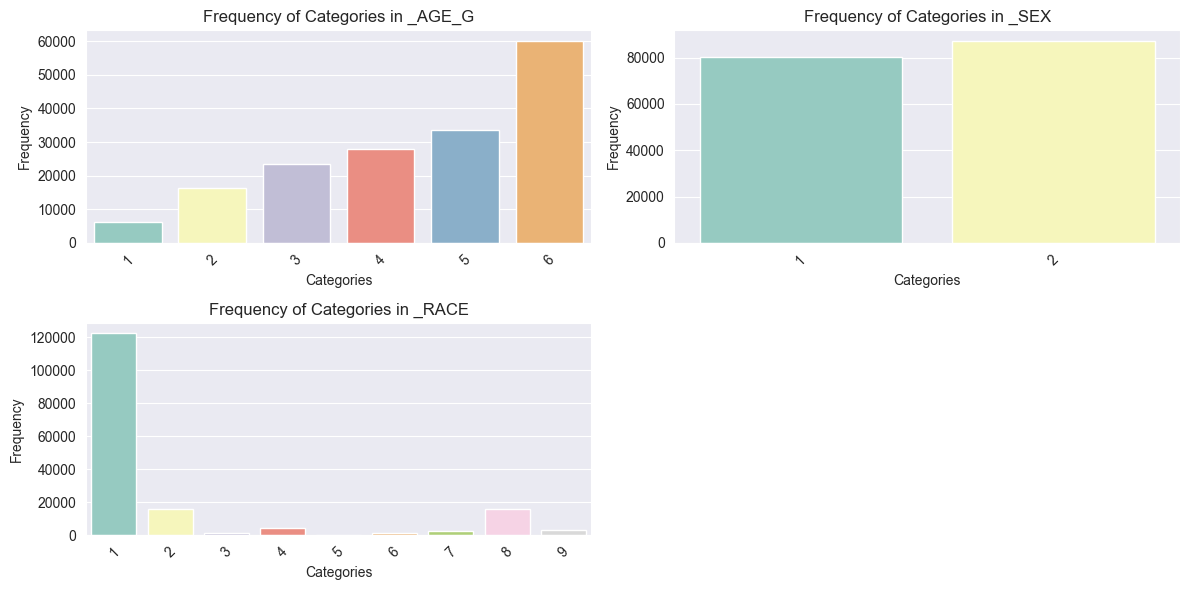

In [19]:
# Split variables into groups of five
variable_groups = [dataframes[2].columns[i:i+5] for i in range(0, len(dataframes[2].columns), 5)]

# Plot each group of variables
for group in variable_groups:
    plt.figure(figsize=(12, 6))
    for idx, variable in enumerate(group):
        plt.subplot(math.ceil(len(group)/2), 2, idx+1)
        sns.countplot(data=dataframes[2], x=variable, hue=variable, palette='Set3', legend=False)
        plt.title(f'Frequency of Categories in {variable}')
        plt.xlabel('Categories')
        plt.ylabel('Frequency')
        plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

### Dataset Sample Creation
Create a sample for one of the dataframes for later feature extraction and classification. Another method we can use to take a sample is to split the original dataframe and apply a combination of oversampling and undersampling to the training set.

First way to create a sample: 
- Take all the samples from the minority class
- Define a percentage of samples that you want to take and subtract the number of minority class samples; that will be the number of majority class samples

In [ ]:
# Take all minority samples. Including duplicates
minority_samples = dataframes[2][dataframes[2]['_MICHD'] == 1.0] 
num_minority_samples = len(minority_samples)

"""
Lets say that we want to take p% of the original dataframe as a sample. The first step we have to take is subtract the number of minority samples assuming we have already included them in our sample.
The second step is to add the necessary number of majority samples in our sample until we reach the upper limit which is p% of samples. We can add some of the unique samples from the majority class 
to the sample or we can randomly pick some of them. Below, we add unique samples to the sample.
"""
num_majority_samples =  math.floor(dataframes[2].shape[0] * 0.25) - num_minority_samples
majority_unique_samples = dataframes[2][dataframes[2]['_MICHD'] == 2.0].drop_duplicates()
num_unique_majority_samples = len(majority_unique_samples)

majority_samples = majority_unique_samples.sample(n=num_majority_samples)

dataframe_sample = pd.concat([minority_samples, majority_samples])

Second way to create a sample:
- Perform stratified sampling using a percentage of samples

In [ ]:
# Specify the fraction of samples you want to retain in the subset (e.g., 0.5 for 50%)
subset_fraction = 0.1

# Perform stratified sampling to create a smaller dataframe
dataframe_sample = dataframes[2].groupby('_MICHD', group_keys = False).apply(lambda x: x.sample(frac = subset_fraction))

Third way to create a sample:
- Undersample the majority class so we can keep all instances of the minority class, thereby reducing the overall size of the dataset. The downside of this approach is we lose valuable instances of the majority class.

In [ ]:
# Define the undersampler
undersampler = RandomUnderSampler(random_state=42)

# Separate features (X) and target variable (y)
x = dataframes[2].drop(columns=['_MICHD'])
y = dataframes[2]['_MICHD']

# Perform undersampling
x_resampled, y_resampled = undersampler.fit_resample(x, y)

# Construct the balanced DataFrame
dataframe_sample = pd.concat([x_resampled, y_resampled], axis=1)

In [ ]:
dataframe_sample.shape

In [ ]:
dataframe_sample['_MICHD'].value_counts()

In [ ]:
dataframe_sample.info()

## Feature Selection with SVM
Feature selection with a linear SVM is time consuming. However, we can use undersampling to take all the instances of the minority class and reduce the size of the majority class. Use this methodology only if you want to improve the results of the classification.

In [ ]:
def calc_cost(y_true, y_pred, cost_matrix):
    conf = confusion_matrix(y_true,y_pred).T
    return np.sum(conf * cost_matrix)

In [ ]:
def find_best_params(estimator, params, train_set, validation_set, starting_point = 0):
    train_x = train_set[0]
    train_y = train_set[1]
    test_x = validation_set[0]
    test_y = validation_set[1]
    
    min_cost = np.inf
    best_params = {}  
    full_params_set = []
    
    if type(params) == dict:
        
        for values in product(*params.values()):
            point = dict(zip(params.keys(), values))
            full_params_set.append(point)
        
    elif type(params) == list:
        
        for params_subset in params:
            for values in product(*params_subset.values()):
                point = dict(zip(params_subset.keys(), values))
                full_params_set.append(point)
    
    else:
        return []
    
    steps = len(full_params_set)
    counter = starting_point
    print(f"Testing {steps} models in total.")
    start = time.time()
    
    performance_log = []
    
    for params in full_params_set[starting_point:]:

        estimator.set_params(**params)
        estimator.fit(train_x,train_y)
        pred_y = estimator.predict(test_x)
        cost_matrix = np.matrix([[0,1], [40,0]])
        cost = calc_cost(test_y, pred_y, cost_matrix)

        if cost < min_cost:
            min_cost = cost
            best_params = params
        
        log = f"{counter}/{steps} | Cost: {cost} | Elapsed: {int((time.time()-start)*100)/100}s | {params}"
        performance_log.append(log)
        print("________________________________________________________________________________________")
        print(log)
        print("________________________________________________________________________________________")
        counter += 1
        if counter % 10 == 0:
            with open("Performance_Logs.txt", "w") as f:
                f.write("\n".join(performance_log))

    return best_params

In [ ]:
linear_params = {"C":[0.1,1.0,10.0,100.0],"kernel":["linear"]}

# If the columns are all type float, then there is no need to apply label encoding
#LE = LabelEncoder()
#data_encoded = dataframe_sample.apply(LE.fit_transform, axis = 1)

target_column = "_MICHD"

y = dataframe_sample[target_column]
x = dataframe_sample.drop(columns = [target_column])

x_train,x_test,y_train,y_test = train_test_split(x, y, test_size = 0.20)
x_train,x_val,y_train,y_val = train_test_split(x_train, y_train, test_size = 0.25)

In [ ]:
best_params = find_best_params(SVC(), linear_params, [x_train, y_train], [x_val, y_val])

In [ ]:
print(best_params)

In [ ]:
classifier = SVC(**best_params)
classifier.fit(x_train, y_train)
weights = zip(list(data.columns),classifier.coef_.todense().data)
weights_sorted = {k: v for k, v in sorted(weights.items(), key=lambda item: item[1])}
with open("Important_Features.json","w") as f:
    json.dump(weights_sorted,f)

## Feature Selection with Random Forests
We can use the GridSearch, or the RandomizedSearch method with the Random Forest algorithm to evaluate the importance of each variable and identify the optimal features for assessing the risk of MI or CHD.

In [ ]:
target_column = "_MICHD"

y = dataframes[2][target_column]
x = dataframes[2].drop(columns = [target_column])

# y = dataframe_sample[target_column]
# x = dataframe_sample.drop(columns = [target_column])

In [ ]:
# Define the cost matrix
cost_matrix = [[0, 0.25],  # Cost of false positive 
               [1, 0]]  # Cost of false negative

In [ ]:
# Define a custom scoring function using the cost matrix
def custom_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    cost = np.sum(cm * cost_matrix)
    return -cost  # Minimize cost, so negative of cost is returned

In [ ]:
# Make the custom scoring function into a scorer object
custom_scorer = make_scorer(custom_score, greater_is_better = False)

### Random Search

In [ ]:
# Define the parameter distributions to sample from
param_dist = {
    'n_estimators': randint(50, 200),
    'max_depth': [None] + list(range(10, 21)),
    'min_samples_split': randint(2, 11)
}

# Initialize a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Initialize RandomizedSearchCV with custom scoring
random_search = RandomizedSearchCV(estimator=rf_classifier, param_distributions=param_dist, n_iter=10, cv=5, 
                                   scoring=custom_scorer, n_jobs=4, random_state=42)


### Grid Search

In [ ]:
# Define the parameter grid to search
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Initialize a Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, n_jobs=4, scoring=custom_scorer)


### Initialize search, output the best parameters, and print feature importance

In [ ]:
random_search.fit(x, y)
#grid_search.fit(x, y)

In [ ]:
# Get the best parameters from the random search
best_params = random_search.best_params_

# Print the best parameters
print("Best Parameters:", best_params)

# Get the best estimator (Random Forest classifier with the best parameters)
best_rf_classifier = random_search.best_estimator_

# Train the best classifier on the entire dataset
best_rf_classifier.fit(x, y)

# Extract feature importance
feature_importances = best_rf_classifier.feature_importances_

Print the importance of each feature if original unaltered variables are used.

In [ ]:
# Sort the features and their importance scores by importance in descending order
sorted_features = sorted(zip(x.columns, feature_importances), key=lambda x: x[1], reverse=True)

# Print all features and their importance scores in descending order
print("\nFeature Importance (Descending Order):")
for feature, importance in sorted_features:
    print(f"{feature}: {importance}")

Print the importance of each feature if one hot encoder is used.

In [ ]:
feature_importance_sum = {}

for feature, importance in zip(x.columns, feature_importances):
    feature_name = re.sub(r'^(.*?)_.+', r'\1', feature)

    if feature_name in feature_importance_sum:
        feature_importance_sum[feature_name] += importance
    else:
        feature_importance_sum[feature_name] = importance

sorted_feature_importance_sum = sorted(feature_importance_sum.items(), key=lambda x: x[1], reverse=True)

for feature, importance_sum in sorted_feature_importance_sum:
    print(f"{feature}: {importance_sum}")

Print the top features if original unaltered variables are used.

In [ ]:
num_top_features = 23  # You can adjust this number based on your preference
top_feature_indices = feature_importances.argsort()[-num_top_features:][::-1]
top_features = x.columns[top_feature_indices]

print("Top features:")
for feature in top_features:
    print(feature)

Print the top features if one hot encoder is used.

In [ ]:
top_features = [sorted_feature_importance_sum[i][0] for i in range(13)]

complete_features = []

for feature in top_features:
  for column in dataframe_sample.columns:
      if column.startswith(feature):
          suffix = column[len(feature):].lstrip('_')
          if suffix != '':
            complete_part = feature + '_' + suffix
          else:
            complete_part = feature

          complete_features.append(complete_part)

top_features = complete_features
for complete_feat in top_features: print(complete_feat)

# ***Classification with Data Mining Methods***

## Class Frequency of the Target Variable

<Axes: xlabel='_MICHD', ylabel='count'>

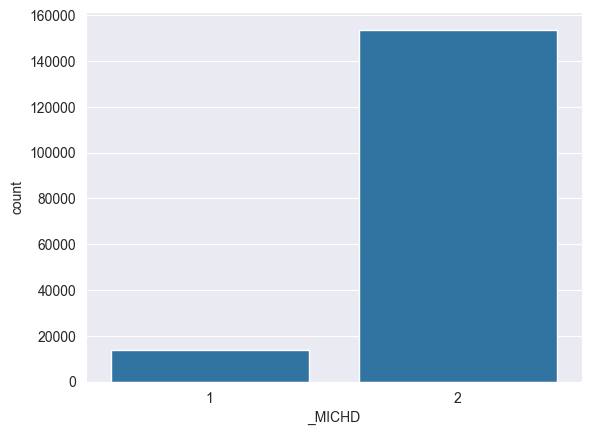

In [20]:
# Counts for the "Had_CHD_MI" variable
sns.countplot(data=dataframes[2],x='_MICHD')

<h1 style="text-align: center;">Generation of Synthetic Data</h1>

<h2> Here we try different oversampling methods and for each variant we run the model and save the results </h2>

In [21]:
SMOTE_data = dataframes[2].copy()

In [22]:
SMOTE_data['_MICHD'].value_counts()

_MICHD
2    153711
1     13872
Name: count, dtype: int64

In [23]:
SMOTE_data.drop_duplicates()['_MICHD'].value_counts()

_MICHD
2    120781
1     12936
Name: count, dtype: int64

In [24]:
target_column = "_MICHD"

<h3 style="text-align: center;"> First variant: Borderline SMOTE </h3>

#### Split data before applying Borderline SMOTE

In [ ]:
SMOTE_train_data, SMOTE_test_data = train_test_split(SMOTE_data, test_size=0.20, stratify=SMOTE_data['_MICHD'])

In [ ]:
# Separate the dataframe into minority and majority classes
minority_df = SMOTE_data[SMOTE_data['_MICHD'] == 1.0]
majority_df = SMOTE_data[SMOTE_data['_MICHD'] == 2.0]

# Split the minority class into training and testing sets
minority_train, minority_test = train_test_split(minority_df, test_size=0.1)

# Split the majority class into training and testing sets
majority_train, majority_test = train_test_split(majority_df, test_size=0.3)

# Concatenate the training and testing sets for both classes
train_set = pd.concat([minority_train, majority_train])
test_set = pd.concat([minority_test, majority_test])

# Shuffle the rows in the testing set
test_set = test_set.sample(frac=1)

# Ensure that the testing set does not contain samples from the training set
test_set = test_set[~test_set.index.isin(train_set.index)]

# Verify the class distribution in the training and testing sets
print("Training set class distribution:")
print(train_set['_MICHD'].value_counts())
print("\nTesting set class distribution:")
print(test_set['_MICHD'].value_counts())

In [ ]:
# Generate synthetic data for the original imbalanced data
resampled_data = BorderlineSMOTE().fit_resample(train_set.drop(columns = ['_MICHD']), 
                                        train_set['_MICHD'])
train_set = resampled_data[0]
train_set[target_column] = resampled_data[1].to_numpy()

In [ ]:
# Counts for the "Had_CHD_MI" variable
sns.countplot(data=train_set,x='_MICHD')

In [ ]:
# 0: Reported having MI or CHD
# 1: Did not report having MI or CHD

train_set['_MICHD'] = train_set['_MICHD'].map({1.0: 0, 2.0: 1})
test_set['_MICHD'] = test_set['_MICHD'].map({1.0: 0, 2.0: 1})

#### Apply Borderline SMOTE without spliting data

In [25]:
# Generate synthetic data for the original imbalanced data
resampled_data = BorderlineSMOTE().fit_resample(SMOTE_data.drop(columns = ['_MICHD']), 
                                        SMOTE_data['_MICHD'])
SMOTE_data = resampled_data[0]
SMOTE_data[target_column] = resampled_data[1].to_numpy()

# This variable specifies the oversampling method we use. 1 is for the first method, 2 is for the second and so on. Based on this variable, the results are saved to the correct dataframe.
method=1

<Axes: xlabel='_MICHD', ylabel='count'>

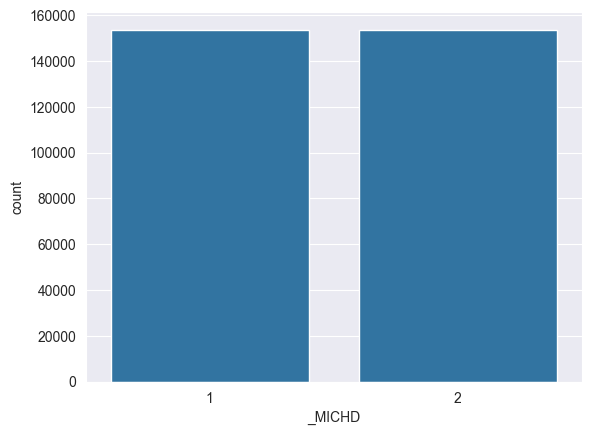

In [26]:
# Counts for the "Had_CHD_MI" variable
sns.countplot(data=SMOTE_data,x='_MICHD')

In [27]:
# 0: Reported having MI or CHD
# 1: Did not report having MI or CHD

SMOTE_data['_MICHD'] = SMOTE_data['_MICHD'].map({1.0: 0, 2.0: 1})

In [28]:
# In this dataframe we will keep the results for every oversampling variant and for all the methods we use. In rows, we have the metrics and in columns, we have the classifiers.
BorderlineSMOTE_loss = pd.DataFrame(columns = ['XGBoost', 'Decision Tree', 'GaussianNB', 'Random Forests', 'KNN', 'Logistic regression'])
BorderlineSMOTE_precision = pd.DataFrame(columns=['XGBoost', 'Decision Tree', 'GaussianNB', 'Random Forests', 'KNN', 'Logistic regression'])
BorderlineSMOTE_recall = pd.DataFrame(columns=['XGBoost', 'Decision Tree', 'GaussianNB', 'Random Forests', 'KNN', 'Logistic regression'])
BorderlineSMOTE_f1_score = pd.DataFrame(columns=['XGBoost', 'Decision Tree', 'GaussianNB', 'Random Forests', 'KNN', 'Logistic regression'])

<h3 style="text-align: center;"> Second variant: SMOTE-Tomek </h3>

In [ ]:
# Generate synthetic data for the original imbalanced data
from imblearn.combine import SMOTETomek

smote_tomek = SMOTETomek()
resampled_data = smote_tomek.fit_resample(SMOTE_data.drop(columns=['_MICHD']), SMOTE_data['_MICHD'])

SMOTE_data = resampled_data[0]
SMOTE_data[target_column] = resampled_data[1].to_numpy()

method=2

In [ ]:
# Counts for the "Had_CHD_MI" variable
sns.countplot(data=SMOTE_data,x='_MICHD')

In [ ]:
# 0: Reported having MI or CHD
# 1: Did not report having MI or CHD

SMOTE_data['_MICHD'] = SMOTE_data['_MICHD'].map({1.0: 0, 2.0: 1})

In [ ]:
# In this dataframe we will keep the results for every oversampling variant and for all the methods we use. In rows, we have the metrics and in columns, we have the classifiers.
smote_tomek_loss = pd.DataFrame(columns = ['XGBoost', 'Decision Tree', 'GaussianNB', 'Random Forests', 'KNN', 'Logistic regression'])
smote_tomek_precision = pd.DataFrame(columns=['XGBoost', 'Decision Tree', 'GaussianNB', 'Random Forests', 'KNN', 'Logistic regression'])
smote_tomek_recall = pd.DataFrame(columns=['XGBoost', 'Decision Tree', 'GaussianNB', 'Random Forests', 'KNN', 'Logistic regression'])
smote_tomek_f1_score = pd.DataFrame(columns=['XGBoost', 'Decision Tree', 'GaussianNB', 'Random Forests', 'KNN', 'Logistic regression'])

<h3 style="text-align: center;"> Third variant: ADASYN (Adaptive Synthetic Sampling) </h3>

ADASYN is an extension of SMOTE that adaptively generates samples according to the local density of minority samples. It focuses more on regions where the class imbalance is more severe.

In [ ]:
from imblearn.over_sampling import ADASYN

adasyn = ADASYN()
resampled_data = adasyn.fit_resample(SMOTE_data.drop(columns=['_MICHD']), SMOTE_data['_MICHD'])

SMOTE_data = resampled_data[0]
SMOTE_data[target_column] = resampled_data[1].to_numpy()

method=3

In [ ]:
# Counts for the "Had_CHD_MI" variable
sns.countplot(data=SMOTE_data,x='_MICHD')

In [ ]:
# 0: Reported having MI or CHD
# 1: Did not report having MI or CHD

SMOTE_data['_MICHD'] = SMOTE_data['_MICHD'].map({1.0: 0, 2.0: 1})

In [ ]:
# In this dataframe we will keep the results for every oversampling variant and for all the methods we use. In rows, we have the metrics and in columns, we have the classifiers.
adasyn_loss = pd.DataFrame(columns = ['XGBoost', 'Decision Tree', 'GaussianNB', 'Random Forests', 'KNN', 'Logistic regression'])
adasyn_precision = pd.DataFrame(columns=['XGBoost', 'Decision Tree', 'GaussianNB', 'Random Forests', 'KNN', 'Logistic regression'])
adasyn_recall = pd.DataFrame(columns=['XGBoost', 'Decision Tree', 'GaussianNB', 'Random Forests', 'KNN', 'Logistic regression'])
adasyn_f1_score = pd.DataFrame(columns=['XGBoost', 'Decision Tree', 'GaussianNB', 'Random Forests', 'KNN', 'Logistic regression'])

<h3 style="text-align: center;"> Fourth variant: SMOTE </h3>

In [ ]:
from imblearn.over_sampling import SMOTE

resampled_data = SMOTE().fit_resample(SMOTE_data.drop(columns=['_MICHD']), SMOTE_data['_MICHD'])

SMOTE_data = resampled_data[0]
SMOTE_data[target_column] = resampled_data[1].to_numpy()

method=4

In [ ]:
# Counts for the "Had_CHD_MI" variable
sns.countplot(data=SMOTE_data,x='_MICHD')

In [ ]:
# 0: Reported having MI or CHD
# 1: Did not report having MI or CHD

SMOTE_data['_MICHD'] = SMOTE_data['_MICHD'].map({1.0: 0, 2.0: 1})

In [ ]:
# In this dataframe we will keep the results for every oversampling variant and for all the methods we use. In rows, we have the metrics and in columns, we have the classifiers.
SMOTE_loss = pd.DataFrame(columns = ['XGBoost', 'Decision Tree', 'GaussianNB', 'Random Forests', 'KNN', 'Logistic regression'])
SMOTE_precision = pd.DataFrame(columns=['XGBoost', 'Decision Tree', 'GaussianNB', 'Random Forests', 'KNN', 'Logistic regression'])
SMOTE_recall = pd.DataFrame(columns=['XGBoost', 'Decision Tree', 'GaussianNB', 'Random Forests', 'KNN', 'Logistic regression'])
SMOTE_f1_score = pd.DataFrame(columns=['XGBoost', 'Decision Tree', 'GaussianNB', 'Random Forests', 'KNN', 'Logistic regression'])

## Classification

In [29]:
# Define the cost matrix
cost_matrix = [ 
    [0, 0.25],  
    [1, 0]
] 

### ***XGBoost***

#### XGBoost for pre-split data

In [30]:
# # Calculate the scale_pos_weight based on the corrected cost matrix
# scale_pos_weight = cost_matrix[1][0] / cost_matrix[0][1]
# 
# # Create an XGBClassifier object
# xgb_model = XGBClassifier(n_estimators = 500, learning_rate = 0.1, scale_pos_weight=scale_pos_weight)
# 
# # Train the classifier
# xgb_model.fit(train_set.drop(columns=['_MICHD']), train_set['_MICHD'])
# 
# # Predict the response for test dataset
# y_pred = xgb_model.predict(test_set.drop(columns=['_MICHD']))
# 
# # Print the confusion matrix
# print('Confusion Matrix:')
# print(confusion_matrix(test_set['_MICHD'], y_pred))

#### XGBoost for non-split data

In [31]:
# Split the balanced dataset to a set of training and testing samples 
x_train, x_test, y_train, y_test = train_test_split(SMOTE_data.drop(columns=['_MICHD']), SMOTE_data['_MICHD'], test_size=0.25, random_state=SEED)

In [32]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 300, 500],  # Number of trees in the forest
    'learning_rate': [0.05, 0.1, 0.2],  # Learning rate
    'max_depth': [3, 5, 7],  # Maximum depth of each tree
    'min_child_weight': [1, 3, 5],  # Minimum sum of instance weight needed in a child
}

# Create an XGBClassifier object
xgb_model = XGBClassifier(random_state=SEED)

# Create GridSearchCV object
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Perform grid search
grid_search.fit(x_train, y_train)

# Get the best parameters and the best estimator
best_params = grid_search.best_params_
best_xgb_model = grid_search.best_estimator_

# Train the best estimator
best_xgb_model.fit(x_train, y_train)

# Predict the response for test dataset
y_pred = best_xgb_model.predict(x_test)

# Print the confusion matrix
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred).T)

total_cost = np.sum(confusion_matrix(y_test, y_pred).T * cost_matrix)
print(f"\nTotal Cost: {total_cost}") 

# Print classification report for additional evaluation metrics
print('\nClassification Report:')
print(classification_report(y_test, y_pred, target_names=["Reported having MI or CHD", "Did not report having MI or CHD"]))

# Extract macro metrics from the classification report
metrics_dict = classification_report(y_test, y_pred, target_names=["Reported having MI or CHD", "Did not report having MI or CHD"], output_dict=True)['macro avg']

if method == 1:
    BorderlineSMOTE_loss.loc['Total Cost baseline', 'XGBoost'] = total_cost
    BorderlineSMOTE_precision.loc['macro precision baseline', 'XGBoost'] = metrics_dict['precision']
    BorderlineSMOTE_recall.loc['macro recall baseline', 'XGBoost'] = metrics_dict['recall']
    BorderlineSMOTE_f1_score.loc['macro f1-score baseline', 'XGBoost'] = metrics_dict['f1-score']
elif method == 2:
    smote_tomek_loss.loc['Total Cost baseline', 'XGBoost'] = total_cost
    smote_tomek_precision.loc['macro precision baseline', 'XGBoost'] = metrics_dict['precision']
    smote_tomek_recall.loc['macro recall baseline', 'XGBoost'] = metrics_dict['recall']
    smote_tomek_f1_score.loc['macro f1-score baseline', 'XGBoost'] = metrics_dict['f1-score']
elif method == 3:
    adasyn_loss.loc['Total Cost baseline', 'XGBoost'] = total_cost
    adasyn_precision.loc['macro precision baseline', 'XGBoost'] = metrics_dict['precision']
    adasyn_recall.loc['macro recall baseline', 'XGBoost'] = metrics_dict['recall']
    adasyn_f1_score.loc['macro f1-score baseline', 'XGBoost'] = metrics_dict['f1-score']
else:
    SMOTE_loss.loc['Total Cost baseline', 'XGBoost'] = total_cost
    SMOTE_precision.loc['macro precision baseline', 'XGBoost'] = metrics_dict['precision']
    SMOTE_recall.loc['macro recall baseline', 'XGBoost'] = metrics_dict['recall']
    SMOTE_f1_score.loc['macro f1-score baseline', 'XGBoost'] = metrics_dict['f1-score']

Confusion Matrix:
[[35056  7033]
 [ 3650 31117]]

Total Cost: 5408.25

Classification Report:
                                 precision    recall  f1-score   support

      Reported having MI or CHD       0.83      0.91      0.87     38706
Did not report having MI or CHD       0.90      0.82      0.85     38150

                       accuracy                           0.86     76856
                      macro avg       0.86      0.86      0.86     76856
                   weighted avg       0.86      0.86      0.86     76856



In [33]:
# import matplotlib.pyplot as plt
# 
# # Get feature importances
# importances = best_xgb_model.feature_importances_
# features = x_train.columns
# 
# # Sort feature importances in descending order
# indices = np.argsort(importances)[::-1]
# 
# # Plot
# plt.figure(figsize=(10, 6))
# plt.title("Feature Importances (XGBoost)")
# plt.bar(range(x_train.shape[1]), importances[indices], align="center")
# plt.xticks(range(x_train.shape[1]), [features[i] for i in indices], rotation=90)
# plt.xlabel("Feature")
# plt.ylabel("Importance")
# plt.tight_layout()
# 
# # Save the plot as an image file
# plt.savefig("feature_importance_plot (XGBoost).png")
# 
# # Display the plot
# plt.show()

In [34]:
# import shap
# 
# # Explain the model's predictions using SHAP
# explainer = shap.TreeExplainer(best_xgb_model)
# shap_values = explainer.shap_values(x_train)
# 
# # Save SHAP values to a file
# np.save('shap_values.npy', shap_values)
# 
# # Plot the SHAP values
# shap.summary_plot(shap_values, features=x_train, feature_names=x_train.columns, show=False)
# plt.savefig('shap_summary_plot.png', bbox_inches='tight')  # Save the plot as an image
# plt.show()

In [35]:
def predict(y_prob, cost_m):
    t_BMR = (cost_m[1][0] - cost_m[1][1])/(cost_m[0][1] - cost_m[1][1] - cost_m[0][0] + cost_m[1][0])
    y_pred = np.greater(y_prob[:, 1], t_BMR).astype(int)
    
    return y_pred

from sklearn.calibration import CalibratedClassifierCV

# Create an XGBClassifier object
xgb_model = CalibratedClassifierCV(XGBClassifier(**best_params, random_state=SEED), method="isotonic", cv=10)

# Train the classifier
xgb_model.fit(x_train, y_train)

# Predict the response for test dataset
y_prob = xgb_model.predict_proba(x_test)
y_pred = predict(y_prob, cost_matrix)
    
# Print the confusion matrix
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred).T)

total_cost = np.sum(confusion_matrix(y_test, y_pred).T * cost_matrix)
print(f"\nTotal loss Cost: {total_cost}") 

# Print classification report for additional evaluation metrics
print('\nClassification Report:')
print(classification_report(y_test, y_pred, target_names = ["Reported having MI or CHD", "Did not report having MI or CHD"]))

# Extract macro metrics from the classification report
metrics_dict = classification_report(y_test, y_pred, target_names=["Reported having MI or CHD", "Did not report having MI or CHD"], output_dict=True)['macro avg']

if method == 1:
    BorderlineSMOTE_loss.loc['Total Cost MEC', 'XGBoost'] = total_cost
    BorderlineSMOTE_precision.loc['macro precision MEC', 'XGBoost'] = metrics_dict['precision']
    BorderlineSMOTE_recall.loc['macro recall MEC', 'XGBoost'] = metrics_dict['recall']
    BorderlineSMOTE_f1_score.loc['macro f1-score MEC', 'XGBoost'] = metrics_dict['f1-score']
elif method == 2:
    smote_tomek_loss.loc['Total Cost MEC', 'XGBoost'] = total_cost
    smote_tomek_precision.loc['macro precision MEC', 'XGBoost'] = metrics_dict['precision']
    smote_tomek_recall.loc['macro recall MEC', 'XGBoost'] = metrics_dict['recall']
    smote_tomek_f1_score.loc['macro f1-score MEC', 'XGBoost'] = metrics_dict['f1-score']
elif method == 3:
    adasyn_loss.loc['Total Cost MEC', 'XGBoost'] = total_cost
    adasyn_precision.loc['macro precision MEC', 'XGBoost'] = metrics_dict['precision']
    adasyn_recall.loc['macro recall MEC', 'XGBoost'] = metrics_dict['recall']
    adasyn_f1_score.loc['macro f1-score MEC', 'XGBoost'] = metrics_dict['f1-score']
else:
    SMOTE_loss.loc['Total Cost MEC', 'XGBoost'] = total_cost
    SMOTE_precision.loc['macro precision MEC', 'XGBoost'] = metrics_dict['precision']
    SMOTE_recall.loc['macro recall MEC', 'XGBoost'] = metrics_dict['recall']
    SMOTE_f1_score.loc['macro f1-score MEC', 'XGBoost'] = metrics_dict['f1-score']

Confusion Matrix:
[[37504 12156]
 [ 1202 25994]]

Total loss Cost: 4241.0

Classification Report:
                                 precision    recall  f1-score   support

      Reported having MI or CHD       0.76      0.97      0.85     38706
Did not report having MI or CHD       0.96      0.68      0.80     38150

                       accuracy                           0.83     76856
                      macro avg       0.86      0.83      0.82     76856
                   weighted avg       0.85      0.83      0.82     76856



In [36]:
# Calculate the scale_pos_weight based on the corrected cost matrix
scale_pos_weight = cost_matrix[1][0] / cost_matrix[0][1]

# Create an XGBClassifier object
xgb_model = XGBClassifier(**best_params, scale_pos_weight=scale_pos_weight, random_state=SEED)

# Train the classifier
xgb_model.fit(x_train, y_train)

# Predict the response for test dataset
y_pred = xgb_model.predict(x_test)

# Print the confusion matrix
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred).T)

total_cost = np.sum(confusion_matrix(y_test, y_pred).T * cost_matrix)
print(f"\nTotal loss Cost: {total_cost}") 

# Print classification report for additional evaluation metrics
print('\nClassification Report:')
print(classification_report(y_test, y_pred, target_names = ["Reported having MI or CHD", "Did not report having MI or CHD"]))

# Extract macro metrics from the classification report
metrics_dict = classification_report(y_test, y_pred, target_names=["Reported having MI or CHD", "Did not report having MI or CHD"], output_dict=True)['macro avg']

if method == 1:
    BorderlineSMOTE_loss.loc['Total Cost weighting', 'XGBoost'] = total_cost
    BorderlineSMOTE_precision.loc['macro precision weighting', 'XGBoost'] = metrics_dict['precision']
    BorderlineSMOTE_recall.loc['macro recall weighting', 'XGBoost'] = metrics_dict['recall']
    BorderlineSMOTE_f1_score.loc['macro f1-score weighting', 'XGBoost'] = metrics_dict['f1-score']
elif method == 2:
    smote_tomek_loss.loc['Total Cost weighting', 'XGBoost'] = total_cost
    smote_tomek_precision.loc['macro precision weighting', 'XGBoost'] = metrics_dict['precision']
    smote_tomek_recall.loc['macro recall weighting', 'XGBoost'] = metrics_dict['recall']
    smote_tomek_f1_score.loc['macro f1-score weighting', 'XGBoost'] = metrics_dict['f1-score']
elif method == 3:
    adasyn_loss.loc['Total Cost weighting', 'XGBoost'] = total_cost
    adasyn_precision.loc['macro precision weighting', 'XGBoost'] = metrics_dict['precision']
    adasyn_recall.loc['macro recall weighting', 'XGBoost'] = metrics_dict['recall']
    adasyn_f1_score.loc['macro f1-score weighting', 'XGBoost'] = metrics_dict['f1-score']
else:
    SMOTE_loss.loc['Total Cost weighting', 'XGBoost'] = total_cost
    SMOTE_precision.loc['macro precision weighting', 'XGBoost'] = metrics_dict['precision']
    SMOTE_recall.loc['macro recall weighting', 'XGBoost'] = metrics_dict['recall']
    SMOTE_f1_score.loc['macro f1-score weighting', 'XGBoost'] = metrics_dict['f1-score']

Confusion Matrix:
[[25598  2479]
 [13108 35671]]

Total loss Cost: 13727.75

Classification Report:
                                 precision    recall  f1-score   support

      Reported having MI or CHD       0.91      0.66      0.77     38706
Did not report having MI or CHD       0.73      0.94      0.82     38150

                       accuracy                           0.80     76856
                      macro avg       0.82      0.80      0.79     76856
                   weighted avg       0.82      0.80      0.79     76856



### ***Decision Tree Classifier***

In [37]:
from io import StringIO

# Visualize the decision tree
def show_decision_tree_classifier(model, features):
  dot_data = StringIO()
  export_graphviz(model,
                  out_file=dot_data,
                  filled=False,
                  rounded=True,
                  special_characters=False,
                  impurity=True,
                  precision=2,
                  rotate=False,
                  feature_names=features,
                  fontname='arial',
                  label='all',
                  class_names=['1', '2', '3', '4', '5', '6'])

  graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
  graph.write_png('DecisionTree.png')

  return graph

#### Decision Tree for pre-split data

In [38]:
# # Create a Decision Tree Classifier object
# dt = DecisionTreeClassifier()
# 
# # Train the classifier
# dt.fit(train_set.drop(columns=['_MICHD']), train_set['_MICHD'], sample_weight=cost_matrix)
# 
# # Predict the response for test dataset
# y_pred = dt.predict(test_set.drop(columns=['_MICHD']))
# 
# # Print the confusion matrix and a classification report
# print('Confusion Matrix:')
# print(confusion_matrix(test_set['_MICHD'], y_pred))
# 
# print(classification_report(test_set['_MICHD'], y_pred))

#### Decision Tree for non-split data

In [39]:
# Split the balanced dataset to a set of training and testing samples 
x_train, x_test, y_train, y_test = train_test_split(SMOTE_data.drop(columns=['_MICHD']), SMOTE_data['_MICHD'], test_size=0.25, random_state=SEED)

In [40]:
from sklearn.model_selection import GridSearchCV

# Define the adjusted parameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2', 0.5, 0.7]  # Adjusted max_features values
}

# Create a Decision Tree Classifier object
dt = DecisionTreeClassifier(random_state=SEED)

# Instantiate the grid search with 5-fold cross-validation
grid_search = GridSearchCV(dt, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(x_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Train the classifier with the best parameters
best_dt = DecisionTreeClassifier(random_state=SEED, **best_params)
best_dt.fit(x_train, y_train)

# Predict the response for test dataset using the best classifier
y_pred = best_dt.predict(x_test)

# Print the confusion matrix and a classification report
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred).T)

total_cost = np.sum(confusion_matrix(y_test, y_pred).T * cost_matrix)
print(f"\nTotal Cost: {total_cost}") 

print(classification_report(y_test, y_pred))

# Extract macro metrics from the classification report
metrics_dict = classification_report(y_test, y_pred, target_names=["Reported having MI or CHD", "Did not report having MI or CHD"], output_dict=True)['macro avg']

if method==1:
    BorderlineSMOTE_loss.loc['Total Cost baseline', 'Decision Tree'] = total_cost
    BorderlineSMOTE_precision.loc['macro precision baseline', 'Decision Tree'] = metrics_dict['precision']
    BorderlineSMOTE_recall.loc['macro recall baseline', 'Decision Tree'] = metrics_dict['recall']
    BorderlineSMOTE_f1_score.loc['macro f1-score baseline', 'Decision Tree'] = metrics_dict['f1-score']
elif method==2:
    smote_tomek_loss.loc['Total Cost baseline', 'Decision Tree'] = total_cost
    smote_tomek_precision.loc['macro precision baseline', 'Decision Tree'] = metrics_dict['precision']
    smote_tomek_recall.loc['macro recall baseline', 'Decision Tree'] = metrics_dict['recall']
    smote_tomek_f1_score.loc['macro f1-score baseline', 'Decision Tree'] = metrics_dict['f1-score']
elif method==3:
    adasyn_loss.loc['Total Cost baseline', 'Decision Tree'] = total_cost
    adasyn_precision.loc['macro precision baseline', 'Decision Tree'] = metrics_dict['precision']
    adasyn_recall.loc['macro recall baseline', 'Decision Tree'] = metrics_dict['recall']
    adasyn_f1_score.loc['macro f1-score baseline', 'Decision Tree'] = metrics_dict['f1-score']
else:
    SMOTE_loss.loc['Total Cost baseline', 'Decision Tree'] = total_cost
    SMOTE_precision.loc['macro precision baseline', 'Decision Tree'] = metrics_dict['precision']
    SMOTE_recall.loc['macro recall baseline', 'Decision Tree'] = metrics_dict['recall']
    SMOTE_f1_score.loc['macro f1-score baseline', 'Decision Tree'] = metrics_dict['f1-score']

Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 0.5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Confusion Matrix:
[[36539  6298]
 [ 2167 31852]]

Total Cost: 3741.5
              precision    recall  f1-score   support

           0       0.85      0.94      0.90     38706
           1       0.94      0.83      0.88     38150

    accuracy                           0.89     76856
   macro avg       0.89      0.89      0.89     76856
weighted avg       0.89      0.89      0.89     76856



In [41]:
# from sklearn.inspection import permutation_importance
# 
# # Compute permutation feature importance
# perm_importance = permutation_importance(best_dt, x_test, y_test)
# 
# # Get feature names
# feature_names = x_test.columns
# 
# # Get sorted indices of feature importance
# sorted_idx = perm_importance.importances_mean.argsort()
# 
# # Plot permutation feature importance
# plt.figure(figsize=(10, 6))
# plt.barh(range(len(sorted_idx)), perm_importance.importances_mean[sorted_idx], tick_label=feature_names[sorted_idx])
# plt.xlabel('Permutation Importance')
# plt.ylabel('Feature')
# plt.title('Permutation Feature Importance')
# 
# # Save the plot as an image file
# plt.savefig("feature_importance_plot (DecisionTreeClassifier).png")
# 
# # Display the plot
# plt.show()

In [42]:
# import shap
# 
# # Explain the model's predictions using SHAP
# explainer = shap.TreeExplainer(best_dt)
# shap_values = explainer.shap_values(x_train)
# 
# # Save SHAP values to a file
# np.save('shap_values.npy', shap_values)
# 
# # Plot the SHAP values
# shap.summary_plot(shap_values, features=x_train, feature_names=x_train.columns, show=False)
# plt.savefig('shap_summary_plot (dt).png', bbox_inches='tight')  # Save the plot as an image
# plt.show()

In [43]:
def predict(y_prob, cost_m):
    t_BMR = (cost_m[1][0] - cost_m[1][1])/(cost_m[0][1] - cost_m[1][1] - cost_m[0][0] + cost_m[1][0])
    y_pred = np.greater(y_prob[:, 1], t_BMR).astype(int)
    
    return y_pred

from sklearn.calibration import CalibratedClassifierCV

# Create a Decision Tree Classifier object
dt = CalibratedClassifierCV(
    DecisionTreeClassifier(random_state=SEED, **best_params),
    method="isotonic",
    cv=10
)

# Train the classifier
dt.fit(x_train , y_train)

# Predict the response for test dataset
y_prob = dt.predict_proba(x_test)
y_pred = predict(y_prob, cost_matrix)

# Print the confusion matrix and a classification report
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred).T)

total_cost = np.sum(confusion_matrix(y_test, y_pred).T * cost_matrix)
print(f"\nTotal Cost: {total_cost}") 

print(classification_report(y_test, y_pred))

# Extract macro metrics from the classification report
metrics_dict = classification_report(y_test, y_pred, target_names=["Reported having MI or CHD", "Did not report having MI or CHD"], output_dict=True)['macro avg']

if method==1:
    BorderlineSMOTE_loss.loc['Total Cost MEC', 'Decision Tree'] = total_cost
    BorderlineSMOTE_precision.loc['macro precision MEC', 'Decision Tree'] = metrics_dict['precision']
    BorderlineSMOTE_recall.loc['macro recall MEC', 'Decision Tree'] = metrics_dict['recall']
    BorderlineSMOTE_f1_score.loc['macro f1-score MEC', 'Decision Tree'] = metrics_dict['f1-score']
elif method==2:
    smote_tomek_loss.loc['Total Cost MEC', 'Decision Tree'] = total_cost
    smote_tomek_precision.loc['macro precision MEC', 'Decision Tree'] = metrics_dict['precision']
    smote_tomek_recall.loc['macro recall MEC', 'Decision Tree'] = metrics_dict['recall']
    smote_tomek_f1_score.loc['macro f1-score MEC', 'Decision Tree'] = metrics_dict['f1-score']
elif method==3:
    adasyn_loss.loc['Total Cost MEC', 'Decision Tree'] = total_cost
    adasyn_precision.loc['macro precision MEC', 'Decision Tree'] = metrics_dict['precision']
    adasyn_recall.loc['macro recall MEC', 'Decision Tree'] = metrics_dict['recall']
    adasyn_f1_score.loc['macro f1-score MEC', 'Decision Tree'] = metrics_dict['f1-score']
else:
    SMOTE_loss.loc['Total Cost MEC', 'Decision Tree'] = total_cost
    SMOTE_precision.loc['macro precision MEC', 'Decision Tree'] = metrics_dict['precision']
    SMOTE_recall.loc['macro recall MEC', 'Decision Tree'] = metrics_dict['recall']
    SMOTE_f1_score.loc['macro f1-score MEC', 'Decision Tree'] = metrics_dict['f1-score']

Confusion Matrix:
[[38028 11593]
 [  678 26557]]

Total Cost: 3576.25
              precision    recall  f1-score   support

           0       0.77      0.98      0.86     38706
           1       0.98      0.70      0.81     38150

    accuracy                           0.84     76856
   macro avg       0.87      0.84      0.84     76856
weighted avg       0.87      0.84      0.84     76856



In [44]:
# Calculate sample weights based on the corrected cost matrix
sample_weights = np.zeros_like(y_train, dtype=float)
sample_weights[y_train == 0] = cost_matrix[0][1]
sample_weights[y_train == 1] = cost_matrix[1][0]

# Create a Decision Tree Classifier object
dt = DecisionTreeClassifier(random_state=SEED, **best_params)

# Train the classifier
dt.fit(x_train , y_train, sample_weight=sample_weights)

# Predict the response for test dataset
y_pred = dt.predict(x_test)

# Print the confusion matrix and a classification report
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred).T)

total_cost = np.sum(confusion_matrix(y_test, y_pred).T * cost_matrix)
print(f"\nTotal Cost: {total_cost}") 

print(classification_report(y_test, y_pred))

# Extract macro metrics from the classification report
metrics_dict = classification_report(y_test, y_pred, target_names=["Reported having MI or CHD", "Did not report having MI or CHD"], output_dict=True)['macro avg']

if method==1:
    BorderlineSMOTE_loss.loc['Total Cost weighting', 'Decision Tree'] = total_cost
    BorderlineSMOTE_precision.loc['macro precision weighting', 'Decision Tree'] = metrics_dict['precision']
    BorderlineSMOTE_recall.loc['macro recall weighting', 'Decision Tree'] = metrics_dict['recall']
    BorderlineSMOTE_f1_score.loc['macro f1-score weighting', 'Decision Tree'] = metrics_dict['f1-score']
elif method==2:
    smote_tomek_loss.loc['Total Cost weighting', 'Decision Tree'] = total_cost
    smote_tomek_precision.loc['macro precision weighting', 'Decision Tree'] = metrics_dict['precision']
    smote_tomek_recall.loc['macro recall weighting', 'Decision Tree'] = metrics_dict['recall']
    smote_tomek_f1_score.loc['macro f1-score weighting', 'Decision Tree'] = metrics_dict['f1-score']
elif method==3:
    adasyn_loss.loc['Total Cost weighting', 'Decision Tree'] = total_cost
    adasyn_precision.loc['macro precision weighting', 'Decision Tree'] = metrics_dict['precision']
    adasyn_recall.loc['macro recall weighting', 'Decision Tree'] = metrics_dict['recall']
    adasyn_f1_score.loc['macro f1-score weighting', 'Decision Tree'] = metrics_dict['f1-score']
else:
    SMOTE_loss.loc['Total Cost weighting', 'Decision Tree'] = total_cost
    SMOTE_precision.loc['macro precision weighting', 'Decision Tree'] = metrics_dict['precision']
    SMOTE_recall.loc['macro recall weighting', 'Decision Tree'] = metrics_dict['recall']
    SMOTE_f1_score.loc['macro f1-score weighting', 'Decision Tree'] = metrics_dict['f1-score']

Confusion Matrix:
[[33679  5254]
 [ 5027 32896]]

Total Cost: 6340.5
              precision    recall  f1-score   support

           0       0.87      0.87      0.87     38706
           1       0.87      0.86      0.86     38150

    accuracy                           0.87     76856
   macro avg       0.87      0.87      0.87     76856
weighted avg       0.87      0.87      0.87     76856



### ***Gaussian Naive Bayes***

#### NB for pre-split data

In [45]:
# # Create a Gaussian Naive Bayes Classifier object
# gnb = GaussianNB()
# 
# # Train the classifier
# gnb.fit(train_set.drop(columns=['_MICHD']), train_set['_MICHD'], sample_weight=cost_matrix)
# 
# # Predict the response for test dataset
# y_pred = gnb.predict(test_set.drop(columns=['_MICHD']))
# 
# # Print the confusion matrix and a classification report
# print('Confusion Matrix:')
# print(confusion_matrix(test_set['_MICHD'], y_pred))
# 
# print(classification_report(test_set['_MICHD'], y_pred))

#### NB for non-split data

In [92]:
# Split the balanced dataset to a set of training and testing samples 
x_train, x_test, y_train, y_test = train_test_split(SMOTE_data.drop(columns=['_MICHD']), SMOTE_data['_MICHD'], test_size=0.25, random_state=SEED)

In [93]:
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB

# Create a Gaussian Naive Bayes Classifier object
gnb = GaussianNB()

# Define a grid of parameters to search
param_grid = {
    'priors': [None, [0.5, 0.5], [0.3, 0.7], [0.7, 0.3]]  # Example priors to search
}

# Instantiate the grid search with the Gaussian Naive Bayes classifier
grid_search = GridSearchCV(estimator=gnb, param_grid=param_grid, cv=5)

# Fit the grid search to the data
grid_search.fit(x_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Use the best parameters to create a new Gaussian Naive Bayes classifier
best_gnb = GaussianNB(**best_params)

# Train the classifier with the best parameters
best_gnb.fit(x_train, y_train)

# Predict the response for the test dataset
y_pred = best_gnb.predict(x_test)

# Print the confusion matrix and a classification report
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred).T)

total_cost = np.sum(confusion_matrix(y_test, y_pred).T * cost_matrix)
print(f"\nTotal Cost: {total_cost}")

print(classification_report(y_test, y_pred, target_names=["Reported having MI or CHD", "Did not report having MI or CHD"]))

# Extract macro metrics from the classification report
metrics_dict = classification_report(y_test, y_pred, target_names=["Reported having MI or CHD", "Did not report having MI or CHD"], output_dict=True)['macro avg']

if method==1:
    BorderlineSMOTE_loss.loc['Total Cost baseline', 'GaussianNB'] = total_cost
    BorderlineSMOTE_precision.loc['macro precision baseline', 'GaussianNB'] = metrics_dict['precision']
    BorderlineSMOTE_recall.loc['macro recall baseline', 'GaussianNB'] = metrics_dict['recall']
    BorderlineSMOTE_f1_score.loc['macro f1-score baseline', 'GaussianNB'] = metrics_dict['f1-score']
elif method==2:
    smote_tomek_loss.loc['Total Cost baseline', 'GaussianNB'] = total_cost
    smote_tomek_precision.loc['macro precision baseline', 'GaussianNB'] = metrics_dict['precision']
    smote_tomek_recall.loc['macro recall baseline', 'GaussianNB'] = metrics_dict['recall']
    smote_tomek_f1_score.loc['macro f1-score baseline', 'GaussianNB'] = metrics_dict['f1-score']
elif method==3:
    adasyn_loss.loc['Total Cost baseline', 'GaussianNB'] = total_cost
    adasyn_precision.loc['macro precision baseline', 'GaussianNB'] = metrics_dict['precision']
    adasyn_recall.loc['macro recall baseline', 'GaussianNB'] = metrics_dict['recall']
    adasyn_f1_score.loc['macro f1-score baseline', 'GaussianNB'] = metrics_dict['f1-score']
else:
    SMOTE_loss.loc['Total Cost baseline', 'GaussianNB'] = total_cost
    SMOTE_precision.loc['macro precision baseline', 'GaussianNB'] = metrics_dict['precision']
    SMOTE_recall.loc['macro recall baseline', 'GaussianNB'] = metrics_dict['recall']
    SMOTE_f1_score.loc['macro f1-score baseline', 'GaussianNB'] = metrics_dict['f1-score']

Confusion Matrix:
[[33537 14394]
 [ 5169 23756]]

Total Cost: 8767.5
                                 precision    recall  f1-score   support

      Reported having MI or CHD       0.70      0.87      0.77     38706
Did not report having MI or CHD       0.82      0.62      0.71     38150

                       accuracy                           0.75     76856
                      macro avg       0.76      0.74      0.74     76856
                   weighted avg       0.76      0.75      0.74     76856



In [48]:
# # Get SHAP values
# explainer = shap.Explainer(best_gnb, x_train)
# shap_values = explainer(x_test)
# 
# # Plot and save the SHAP summary plot
# shap.summary_plot(shap_values, features=x_test, plot_type='bar', show=False)
# plt.savefig('shap_summary_plot (best_gnb).png')  # Save the plot as PNG file
# plt.show()  # Display the plot

In [94]:
sample_weights = np.zeros_like(y_train, dtype=float)
sample_weights[y_train == 0] = cost_matrix[0][1]
sample_weights[y_train == 1] = cost_matrix[1][0]

# Create a Gaussian Naive Bayes Classifier object
gnb = GaussianNB(**best_params)

# Train the classifier
gnb.fit(x_train , y_train, sample_weight=sample_weights)

# Predict the response for test dataset
y_pred = gnb.predict(x_test)

# Print the confusion matrix and a classification report
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred).T)

total_cost = np.sum(confusion_matrix(y_test, y_pred).T * cost_matrix)
print(f"\nTotal Cost: {total_cost}") 

print(classification_report(y_test, y_pred, target_names=["Reported having MI or CHD", "Did not report having MI or CHD"]))

# Extract macro metrics from the classification report
metrics_dict = classification_report(y_test, y_pred, target_names=["Reported having MI or CHD", "Did not report having MI or CHD"], output_dict=True)['macro avg']

if method==1:
    BorderlineSMOTE_loss.loc['Total Cost weighting', 'GaussianNB'] = total_cost
    BorderlineSMOTE_precision.loc['macro precision weighting', 'GaussianNB'] = metrics_dict['precision']
    BorderlineSMOTE_recall.loc['macro recall weighting', 'GaussianNB'] = metrics_dict['recall']
    BorderlineSMOTE_f1_score.loc['macro f1-score weighting', 'GaussianNB'] = metrics_dict['f1-score']
elif method==2:
    smote_tomek_loss.loc['Total Cost weighting', 'GaussianNB'] = total_cost
    smote_tomek_precision.loc['macro precision weighting', 'GaussianNB'] = metrics_dict['precision']
    smote_tomek_recall.loc['macro recall weighting', 'GaussianNB'] = metrics_dict['recall']
    smote_tomek_f1_score.loc['macro f1-score weighting', 'GaussianNB'] = metrics_dict['f1-score']
elif method==3:
    adasyn_loss.loc['Total Cost weighting', 'GaussianNB'] = total_cost
    adasyn_precision.loc['macro precision weighting', 'GaussianNB'] = metrics_dict['precision']
    adasyn_recall.loc['macro recall weighting', 'GaussianNB'] = metrics_dict['recall']
    adasyn_f1_score.loc['macro f1-score weighting', 'GaussianNB'] = metrics_dict['f1-score']
else:
    SMOTE_loss.loc['Total Cost weighting', 'GaussianNB'] = total_cost
    SMOTE_precision.loc['macro precision weighting', 'GaussianNB'] = metrics_dict['precision']
    SMOTE_recall.loc['macro recall weighting', 'GaussianNB'] = metrics_dict['recall']
    SMOTE_f1_score.loc['macro f1-score weighting', 'GaussianNB'] = metrics_dict['f1-score']

Confusion Matrix:
[[33537 14394]
 [ 5169 23756]]

Total Cost: 8767.5
                                 precision    recall  f1-score   support

      Reported having MI or CHD       0.70      0.87      0.77     38706
Did not report having MI or CHD       0.82      0.62      0.71     38150

                       accuracy                           0.75     76856
                      macro avg       0.76      0.74      0.74     76856
                   weighted avg       0.76      0.75      0.74     76856



In [95]:
def predict(y_prob, cost_m):
    t_BMR = (cost_m[1][0] - cost_m[1][1])/(cost_m[0][1] - cost_m[1][1] - cost_m[0][0] + cost_m[1][0])
    y_pred = np.greater(y_prob[:, 1], t_BMR).astype(int)
    
    return y_pred

from sklearn.calibration import CalibratedClassifierCV

# Create a Gaussian Naive Bayes Classifier object
gnb = CalibratedClassifierCV(GaussianNB(**best_params), method="isotonic", cv=10)

# Train the classifier
gnb.fit(x_train , y_train)

# Predict the response for test dataset
y_prob = gnb.predict_proba(x_test)
y_pred = predict(y_prob, cost_matrix)

# Print the confusion matrix and a classification report
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred).T)

total_cost = np.sum(confusion_matrix(y_test, y_pred).T * cost_matrix)
print(f"\nTotal Cost: {total_cost}") 

print(classification_report(y_test, y_pred, target_names=["Reported having MI or CHD", "Did not report having MI or CHD"]))

# Extract macro metrics from the classification report
metrics_dict = classification_report(y_test, y_pred, target_names=["Reported having MI or CHD", "Did not report having MI or CHD"], output_dict=True)['macro avg']

if method==1:
    BorderlineSMOTE_loss.loc['Total Cost MEC', 'GaussianNB'] = total_cost
    BorderlineSMOTE_precision.loc['macro precision MEC', 'GaussianNB'] = metrics_dict['precision']
    BorderlineSMOTE_recall.loc['macro recall MEC', 'GaussianNB'] = metrics_dict['recall']
    BorderlineSMOTE_f1_score.loc['macro f1-score MEC', 'GaussianNB'] = metrics_dict['f1-score']
elif method==2:
    smote_tomek_loss.loc['Total Cost MEC', 'GaussianNB'] = total_cost
    smote_tomek_precision.loc['macro precision MEC', 'GaussianNB'] = metrics_dict['precision']
    smote_tomek_recall.loc['macro recall MEC', 'GaussianNB'] = metrics_dict['recall']
    smote_tomek_f1_score.loc['macro f1-score MEC', 'GaussianNB'] = metrics_dict['f1-score']
elif method==3:
    adasyn_loss.loc['Total Cost MEC', 'GaussianNB'] = total_cost
    adasyn_precision.loc['macro precision MEC', 'GaussianNB'] = metrics_dict['precision']
    adasyn_recall.loc['macro recall MEC', 'GaussianNB'] = metrics_dict['recall']
    adasyn_f1_score.loc['macro f1-score MEC', 'GaussianNB'] = metrics_dict['f1-score']
else:
    SMOTE_loss.loc['Total Cost MEC', 'GaussianNB'] = total_cost
    SMOTE_precision.loc['macro precision MEC', 'GaussianNB'] = metrics_dict['precision']
    SMOTE_recall.loc['macro recall MEC', 'DeGaussianNB'] = metrics_dict['recall']
    SMOTE_f1_score.loc['macro f1-score MEC', 'GaussianNB'] = metrics_dict['f1-score']

Confusion Matrix:
[[36823 21694]
 [ 1883 16456]]

Total Cost: 7306.5
                                 precision    recall  f1-score   support

      Reported having MI or CHD       0.63      0.95      0.76     38706
Did not report having MI or CHD       0.90      0.43      0.58     38150

                       accuracy                           0.69     76856
                      macro avg       0.76      0.69      0.67     76856
                   weighted avg       0.76      0.69      0.67     76856



### ***Random Forests***

#### RF for pre-split data

In [51]:
# # Create a Random Forests Classifier object
# rf_classifier = RandomForestClassifier(n_estimators=393, max_depth=16)
# 
# # Train the classifier
# rf_classifier.fit(train_set.drop(columns=['_MICHD']), train_set['_MICHD'], sample_weight=cost_matrix)
# 
# # Predict the response for test dataset
# y_pred = rf_classifier.predict(test_set.drop(columns=['_MICHD']))
# 
# # Print the confusion matrix and a classification report
# print('Confusion Matrix:')
# print(confusion_matrix(test_set['_MICHD'], y_pred))
# 
# print(classification_report(test_set['_MICHD'], y_pred))

#### RF for non-split data

In [52]:
# Split the balanced dataset to a set of training and testing samples 
x_train, x_test, y_train, y_test = train_test_split(SMOTE_data.drop(columns=['_MICHD']), SMOTE_data['_MICHD'], test_size=0.25, random_state=SEED)

In [ ]:
from sklearn.model_selection import GridSearchCV

# Define the parameter grid to search
param_grid = {
    'n_estimators': [100, 200, 300, 400],  # Example values, adjust as needed
    'max_depth': [10, 20, 30, None]  # Example values, adjust as needed
}

# Create a Random Forest Classifier object
rf_classifier = RandomForestClassifier(random_state=SEED)

# Instantiate the GridSearchCV object
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(x_train, y_train)

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)

# Use the best estimator to make predictions
best_rf_classifier = grid_search.best_estimator_
y_pred = best_rf_classifier.predict(x_test)

# Print the confusion matrix and a classification report
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred).T)

total_cost = np.sum(confusion_matrix(y_test, y_pred).T * cost_matrix)
print(f"\nTotal Cost: {total_cost}")

print(classification_report(y_test, y_pred, target_names=["Reported having MI or CHD", "Did not report having MI or CHD"]))

# Extract macro metrics from the classification report
metrics_dict = classification_report(y_test, y_pred, target_names=["Reported having MI or CHD", "Did not report having MI or CHD"], output_dict=True)['macro avg']

if method==1:
    BorderlineSMOTE_loss.loc['Total Cost baseline', 'Random Forests'] = total_cost
    BorderlineSMOTE_precision.loc['macro precision baseline', 'Random Forests'] = metrics_dict['precision']
    BorderlineSMOTE_recall.loc['macro recall baseline', 'Random Forests'] = metrics_dict['recall']
    BorderlineSMOTE_f1_score.loc['macro f1-score baseline', 'Random Forests'] = metrics_dict['f1-score']
elif method==2:
    smote_tomek_loss.loc['Total Cost baseline', 'Random Forests'] = total_cost
    smote_tomek_precision.loc['macro precision baseline', 'Random Forests'] = metrics_dict['precision']
    smote_tomek_recall.loc['macro recall baseline', 'Random Forests'] = metrics_dict['recall']
    smote_tomek_f1_score.loc['macro f1-score baseline', 'Random Forests'] = metrics_dict['f1-score']
elif method==3:
    adasyn_loss.loc['Total Cost baseline', 'Random Forests'] = total_cost
    adasyn_precision.loc['macro precision baseline', 'Random Forests'] = metrics_dict['precision']
    adasyn_recall.loc['macro recall baseline', 'Random Forests'] = metrics_dict['recall']
    adasyn_f1_score.loc['macro f1-score baseline', 'Random Forests'] = metrics_dict['f1-score']
else:
    SMOTE_loss.loc['Total Cost baseline', 'Random Forests'] = total_cost
    SMOTE_precision.loc['macro precision baseline', 'Random Forests'] = metrics_dict['precision']
    SMOTE_recall.loc['macro recall baseline', 'Random Forests'] = metrics_dict['recall']
    SMOTE_f1_score.loc['macro f1-score baseline', 'Random Forests'] = metrics_dict['f1-score']

In [54]:
# import matplotlib.pyplot as plt
# 
# # Extract feature importances from the best classifier
# feature_importances = best_rf_classifier.feature_importances_
# 
# # Get the names of the features
# feature_names = x_train.columns  # Assuming x_train is a DataFrame
# 
# # Sort feature importances in descending order
# indices = np.argsort(feature_importances)[::-1]
# 
# # Plot the feature importances
# plt.figure(figsize=(10, 6))
# plt.title("Feature Importances")
# plt.bar(range(x_train.shape[1]), feature_importances[indices], color="b", align="center")
# plt.xticks(range(x_train.shape[1]), [feature_names[i] for i in indices], rotation=90)
# plt.xlim([-1, x_train.shape[1]])
# plt.tight_layout()
# 
# # Save the plot as an image file
# plt.savefig("feature_importance_plot (RandomForestClassifier).png")
# 
# plt.show()

In [55]:
def predict(y_prob, cost_m):
    t_BMR = (cost_m[1][0] - cost_m[1][1])/(cost_m[0][1] - cost_m[1][1] - cost_m[0][0] + cost_m[1][0])
    y_pred = np.greater(y_prob[:, 1], t_BMR).astype(int)
    
    return y_pred


from sklearn.calibration import CalibratedClassifierCV

# Best parameters found from grid search
best_n_estimators = grid_search.best_params_['n_estimators']
best_max_depth = grid_search.best_params_['max_depth']

# Create a Random Forest Classifier object with the best parameters
rf_classifier = CalibratedClassifierCV(
    RandomForestClassifier(n_estimators=best_n_estimators, max_depth=best_max_depth, random_state=SEED),
    method="sigmoid", cv=10)

# Train the classifier
rf_classifier.fit(x_train, y_train)

# Predict the response for test dataset
y_prob = rf_classifier.predict_proba(x_test)
y_pred = predict(y_prob, cost_matrix)

# Print the confusion matrix and a classification report
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred).T)

total_cost = np.sum(confusion_matrix(y_test, y_pred).T * cost_matrix)
print(f"\nTotal Cost: {total_cost}")

print(classification_report(y_test, y_pred, target_names=["Reported having MI or CHD", "Did not report having MI or CHD"]))

# Extract macro metrics from the classification report
metrics_dict = classification_report(y_test, y_pred, target_names=["Reported having MI or CHD", "Did not report having MI or CHD"], output_dict=True)['macro avg']

if method==1:
    BorderlineSMOTE_loss.loc['Total Cost MEC', 'Random Forests'] = total_cost
    BorderlineSMOTE_precision.loc['macro precision MEC', 'Random Forests'] = metrics_dict['precision']
    BorderlineSMOTE_recall.loc['macro recall MEC', 'Random Forests'] = metrics_dict['recall']
    BorderlineSMOTE_f1_score.loc['macro f1-score MEC', 'Random Forests'] = metrics_dict['f1-score']
elif method==2:
    smote_tomek_loss.loc['Total Cost MEC', 'Random Forests'] = total_cost
    smote_tomek_precision.loc['macro precision MEC', 'Random Forests'] = metrics_dict['precision']
    smote_tomek_recall.loc['macro recall MEC', 'Random Forests'] = metrics_dict['recall']
    smote_tomek_f1_score.loc['macro f1-score MEC', 'Random Forests'] = metrics_dict['f1-score']
elif method==3:
    adasyn_loss.loc['Total Cost MEC', 'Random Forests'] = total_cost
    adasyn_precision.loc['macro precision MEC', 'Random Forests'] = metrics_dict['precision']
    adasyn_recall.loc['macro recall MEC', 'Random Forests'] = metrics_dict['recall']
    adasyn_f1_score.loc['macro f1-score MEC', 'Random Forests'] = metrics_dict['f1-score']
else:
    SMOTE_loss.loc['Total Cost MEC', 'Random Forests'] = total_cost
    SMOTE_precision.loc['macro precision MEC', 'Random Forests'] = metrics_dict['precision']
    SMOTE_recall.loc['macro recall MEC', 'Random Forests'] = metrics_dict['recall']
    SMOTE_f1_score.loc['macro f1-score MEC', 'Random Forests'] = metrics_dict['f1-score']

Confusion Matrix:
[[37472  6772]
 [ 1234 31378]]

Total Cost: 2927.0
                                 precision    recall  f1-score   support

      Reported having MI or CHD       0.85      0.97      0.90     38706
Did not report having MI or CHD       0.96      0.82      0.89     38150

                       accuracy                           0.90     76856
                      macro avg       0.90      0.90      0.90     76856
                   weighted avg       0.90      0.90      0.90     76856



In [56]:
sample_weights = np.zeros_like(y_train, dtype=float)
sample_weights[y_train == 0] = cost_matrix[0][1]
sample_weights[y_train == 1] = cost_matrix[1][0]

# Best parameters found from grid search
best_n_estimators = grid_search.best_params_['n_estimators']
best_max_depth = grid_search.best_params_['max_depth']

# Create a Random Forests Classifier object
rf_classifier = RandomForestClassifier(n_estimators=best_n_estimators, max_depth=best_max_depth, random_state=SEED)

# Train the classifier
rf_classifier.fit(x_train , y_train, sample_weight=sample_weights)

# Predict the response for test dataset
y_pred = rf_classifier.predict(x_test)

# Print the confusion matrix and a classification report
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred).T)

total_cost = np.sum(confusion_matrix(y_test, y_pred).T * cost_matrix)
print(f"\nTotal Cost: {total_cost}")

print(classification_report(y_test, y_pred, target_names=["Reported having MI or CHD", "Did not report having MI or CHD"]))

# Extract macro metrics from the classification report
metrics_dict = classification_report(y_test, y_pred, target_names=["Reported having MI or CHD", "Did not report having MI or CHD"], output_dict=True)['macro avg']

if method==1:
    BorderlineSMOTE_loss.loc['Total Cost weighting', 'Random Forests'] = total_cost
    BorderlineSMOTE_precision.loc['macro precision weighting', 'Random Forests'] = metrics_dict['precision']
    BorderlineSMOTE_recall.loc['macro recall weighting', 'Random Forests'] = metrics_dict['recall']
    BorderlineSMOTE_f1_score.loc['macro f1-score weighting', 'Random Forests'] = metrics_dict['f1-score']
elif method==2:
    smote_tomek_loss.loc['Total Cost weighting', 'Random Forests'] = total_cost
    smote_tomek_precision.loc['macro precision weighting', 'Random Forests'] = metrics_dict['precision']
    smote_tomek_recall.loc['macro recall weighting', 'Random Forests'] = metrics_dict['recall']
    smote_tomek_f1_score.loc['macro f1-score weighting', 'Random Forests'] = metrics_dict['f1-score']
elif method==3:
    adasyn_loss.loc['Total Cost weighting', 'Random Forests'] = total_cost
    adasyn_precision.loc['macro precision weighting', 'Random Forests'] = metrics_dict['precision']
    adasyn_recall.loc['macro recall weighting', 'Random Forests'] = metrics_dict['recall']
    adasyn_f1_score.loc['macro f1-score weighting', 'Random Forests'] = metrics_dict['f1-score']
else:
    SMOTE_loss.loc['Total Cost weighting', 'Random Forests'] = total_cost
    SMOTE_precision.loc['macro precision weighting', 'Random Forests'] = metrics_dict['precision']
    SMOTE_recall.loc['macro recall weighting', 'Random Forests'] = metrics_dict['recall']
    SMOTE_f1_score.loc['macro f1-score weighting', 'Random Forests'] = metrics_dict['f1-score']

Confusion Matrix:
[[34546  3935]
 [ 4160 34215]]

Total Cost: 5143.75
                                 precision    recall  f1-score   support

      Reported having MI or CHD       0.90      0.89      0.90     38706
Did not report having MI or CHD       0.89      0.90      0.89     38150

                       accuracy                           0.89     76856
                      macro avg       0.89      0.89      0.89     76856
                   weighted avg       0.89      0.89      0.89     76856



In [57]:
# import shap
# 
# # Calculate SHAP values
# explainer = shap.TreeExplainer(best_rf_classifier)
# shap_values = explainer.shap_values(x_train)
# 
# # Plot SHAP summary plot
# summary_plot = shap.summary_plot(shap_values, x_train, feature_names=feature_names)
# 
# # Save the plot
# summary_plot.savefig("shap_summary_plot.png")

### ***K-Nearest Neighbors (KNN)***

In [58]:
# Split the balanced dataset to a set of training and testing samples 
x_train, x_test, y_train, y_test = train_test_split(SMOTE_data.drop(columns=['_MICHD']), SMOTE_data['_MICHD'], test_size=0.25, random_state=SEED)

In [59]:
from sklearn.model_selection import cross_val_score

# Define a range of k values to try
k_values = range(1, 21)  # You can adjust this range as needed

# Initialize lists to store mean cross-validation scores for each k
mean_cv_scores = []

# Iterate over each k value
for k in k_values:
    # Create a KNeighborsClassifier object with the current k value
    knn_model = KNeighborsClassifier(n_neighbors=k)
    
    # Perform 5-fold cross-validation and compute the mean accuracy
    cv_scores = cross_val_score(knn_model, x_train, y_train, cv=5, scoring='accuracy')
    mean_cv_score = np.mean(cv_scores)
    
    # Append the mean cross-validation score to the list
    mean_cv_scores.append(mean_cv_score)

# Find the index of the k value with the highest mean cross-validation score
best_k_index = np.argmax(mean_cv_scores)

# Get the best value of k
best_k = k_values[best_k_index]

print(f"The best value of k is: {best_k}")

# Create a KNeighborsClassifier object with the best value of k
best_knn_model = KNeighborsClassifier(n_neighbors=best_k)

# Train the classifier
best_knn_model.fit(x_train, y_train)

# Predict the response for the test dataset
y_pred = best_knn_model.predict(x_test)

# Print the confusion matrix
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred).T)

# Calculate and print the total cost
total_cost = np.sum(confusion_matrix(y_test, y_pred).T * cost_matrix)
print(f"\nTotal Cost: {total_cost}") 

# Print the classification report for additional evaluation metrics
print('\nClassification Report:')
print(classification_report(y_test, y_pred, target_names=["Reported having MI or CHD", "Did not report having MI or CHD"]))

# Extract macro metrics from the classification report
metrics_dict = classification_report(y_test, y_pred, target_names=["Reported having MI or CHD", "Did not report having MI or CHD"], output_dict=True)['macro avg']

if method==1:
    BorderlineSMOTE_loss.loc['Total Cost baseline', 'KNN'] = total_cost
    BorderlineSMOTE_precision.loc['macro precision baseline', 'KNN'] = metrics_dict['precision']
    BorderlineSMOTE_recall.loc['macro recall baseline', 'KNN'] = metrics_dict['recall']
    BorderlineSMOTE_f1_score.loc['macro f1-score baseline', 'KNN'] = metrics_dict['f1-score']
elif method==2:
    smote_tomek_loss.loc['Total Cost baseline', 'KNN'] = total_cost
    smote_tomek_precision.loc['macro precision baseline', 'KNN'] = metrics_dict['precision']
    smote_tomek_recall.loc['macro recall baseline', 'KNN'] = metrics_dict['recall']
    smote_tomek_f1_score.loc['macro f1-score baseline', 'KNN'] = metrics_dict['f1-score']
elif method==3:
    adasyn_loss.loc['Total Cost baseline', 'KNN'] = total_cost
    adasyn_precision.loc['macro precision baseline', 'KNN'] = metrics_dict['precision']
    adasyn_recall.loc['macro recall baseline', 'KNN'] = metrics_dict['recall']
    adasyn_f1_score.loc['macro f1-score baseline', 'KNN'] = metrics_dict['f1-score']
else:
    SMOTE_loss.loc['Total Cost baseline', 'KNN'] = total_cost
    SMOTE_precision.loc['macro precision baseline', 'KNN'] = metrics_dict['precision']
    SMOTE_recall.loc['macro recall baseline', 'KNN'] = metrics_dict['recall']
    SMOTE_f1_score.loc['macro f1-score baseline', 'KNN'] = metrics_dict['f1-score']

The best value of k is: 1
Confusion Matrix:
[[35891  7194]
 [ 2815 30956]]

Total Cost: 4613.5

Classification Report:
                                 precision    recall  f1-score   support

      Reported having MI or CHD       0.83      0.93      0.88     38706
Did not report having MI or CHD       0.92      0.81      0.86     38150

                       accuracy                           0.87     76856
                      macro avg       0.87      0.87      0.87     76856
                   weighted avg       0.87      0.87      0.87     76856



In [60]:
def predict(y_prob, cost_m):
    t_BMR = (cost_m[1][0] - cost_m[1][1])/(cost_m[0][1] - cost_m[1][1] - cost_m[0][0] + cost_m[1][0])
    y_pred = np.greater(y_prob[:, 1], t_BMR).astype(int)
    
    return y_pred


from sklearn.calibration import CalibratedClassifierCV

# Create a KNeighborsClassifier object with the best value of k
knn_model = CalibratedClassifierCV(KNeighborsClassifier(n_neighbors=best_k), method='isotonic', cv=10)

# Train the classifier
knn_model.fit(x_train, y_train)

# Predict the response for the test dataset
y_prob = knn_model.predict_proba(x_test)
y_pred = predict(y_prob, cost_matrix)

# Print the confusion matrix
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred).T)

# Calculate and print the total cost
total_cost = np.sum(confusion_matrix(y_test, y_pred).T * cost_matrix)
print(f"\nTotal Cost: {total_cost}") 

# Print the classification report for additional evaluation metrics
print('\nClassification Report:')
print(classification_report(y_test, y_pred, target_names=["Reported having MI or CHD", "Did not report having MI or CHD"]))

# Extract macro metrics from the classification report
metrics_dict = classification_report(y_test, y_pred, target_names=["Reported having MI or CHD", "Did not report having MI or CHD"], output_dict=True)['macro avg']

if method==1:
    BorderlineSMOTE_loss.loc['Total Cost MEC', 'KNN'] = total_cost
    BorderlineSMOTE_precision.loc['macro precision MEC', 'KNN'] = metrics_dict['precision']
    BorderlineSMOTE_recall.loc['macro recall MEC', 'KNN'] = metrics_dict['recall']
    BorderlineSMOTE_f1_score.loc['macro f1-score MEC', 'KNN'] = metrics_dict['f1-score']
elif method==2:
    smote_tomek_loss.loc['Total Cost MEC', 'KNN'] = total_cost
    smote_tomek_precision.loc['macro precision MEC', 'KNN'] = metrics_dict['precision']
    smote_tomek_recall.loc['macro recall MEC', 'KNN'] = metrics_dict['recall']
    smote_tomek_f1_score.loc['macro f1-score MEC', 'KNN'] = metrics_dict['f1-score']
elif method==3:
    adasyn_loss.loc['Total Cost MEC', 'KNN'] = total_cost
    adasyn_precision.loc['macro precision MEC', 'KNN'] = metrics_dict['precision']
    adasyn_recall.loc['macro recall MEC', 'KNN'] = metrics_dict['recall']
    adasyn_f1_score.loc['macro f1-score MEC', 'KNN'] = metrics_dict['f1-score']
else:
    SMOTE_loss.loc['Total Cost MEC', 'KNN'] = total_cost
    SMOTE_precision.loc['macro precision MEC', 'KNN'] = metrics_dict['precision']
    SMOTE_recall.loc['macro recall MEC', 'KNN'] = metrics_dict['recall']
    SMOTE_f1_score.loc['macro f1-score MEC', 'KNN'] = metrics_dict['f1-score']

Confusion Matrix:
[[35891  7194]
 [ 2815 30956]]

Total Cost: 4613.5

Classification Report:
                                 precision    recall  f1-score   support

      Reported having MI or CHD       0.83      0.93      0.88     38706
Did not report having MI or CHD       0.92      0.81      0.86     38150

                       accuracy                           0.87     76856
                      macro avg       0.87      0.87      0.87     76856
                   weighted avg       0.87      0.87      0.87     76856



In [67]:
from sklearn.utils import resample

# sample_weights = np.zeros_like(y_train, dtype=float)
# sample_weights[y_train == 0] = cost_matrix[0][1]
# sample_weights[y_train == 1] = cost_matrix[1][0]

# Convert y_train to a NumPy array
y_train_array = y_train.values

# Get indices of minority class instances
minority_indices = np.where(y_train == 1)[0]

# Replicate minority class instances with their respective weights
x_train_up = np.repeat(x_train.iloc[minority_indices], sample_weights[minority_indices].astype(int), axis=0)
y_train_up = np.repeat(y_train_array[minority_indices], sample_weights[minority_indices].astype(int))

# Concatenate the upsampled minority class with the majority class
x_train_weighted = np.vstack((x_train[y_train == 0], x_train_up))
y_train_weighted = np.hstack((y_train[y_train == 0], y_train_up))

# Create a KNeighborsClassifier object with the best value of k
knn_model = KNeighborsClassifier(n_neighbors=best_k)

# Train the classifier
knn_model.fit(x_train_weighted, y_train_weighted)

# Predict the response for the test dataset
y_pred = knn_model.predict(x_test)

# Print the confusion matrix
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred).T)

# Calculate and print the total cost
total_cost = np.sum(confusion_matrix(y_test, y_pred).T * cost_matrix)
print(f"\nTotal Cost: {total_cost}") 

# Print the classification report for additional evaluation metrics
print('\nClassification Report:')
print(classification_report(y_test, y_pred, target_names=["Reported having MI or CHD", "Did not report having MI or CHD"]))

# Extract macro metrics from the classification report
metrics_dict = classification_report(y_test, y_pred, target_names=["Reported having MI or CHD", "Did not report having MI or CHD"], output_dict=True)['macro avg']

if method==1:
    BorderlineSMOTE_loss.loc['Total Cost weighting', 'KNN'] = total_cost
    BorderlineSMOTE_precision.loc['macro precision weighting', 'KNN'] = metrics_dict['precision']
    BorderlineSMOTE_recall.loc['macro recall weighting', 'KNN'] = metrics_dict['recall']
    BorderlineSMOTE_f1_score.loc['macro f1-score weighting', 'KNN'] = metrics_dict['f1-score']
elif method==2:
    smote_tomek_loss.loc['Total Cost weighting', 'KNN'] = total_cost
    smote_tomek_precision.loc['macro precision weighting', 'KNN'] = metrics_dict['precision']
    smote_tomek_recall.loc['macro recall weighting', 'KNN'] = metrics_dict['recall']
    smote_tomek_f1_score.loc['macro f1-score weighting', 'KNN'] = metrics_dict['f1-score']
elif method==3:
    adasyn_loss.loc['Total Cost weighting', 'KNN'] = total_cost
    adasyn_precision.loc['macro precision weighting', 'KNN'] = metrics_dict['precision']
    adasyn_recall.loc['macro recall weighting', 'KNN'] = metrics_dict['recall']
    adasyn_f1_score.loc['macro f1-score weighting', 'KNN'] = metrics_dict['f1-score']
else:
    SMOTE_loss.loc['Total Cost weighting', 'KNN'] = total_cost
    SMOTE_precision.loc['macro precision weighting', 'KNN'] = metrics_dict['precision']
    SMOTE_recall.loc['macro recall weighting', 'KNN'] = metrics_dict['recall']
    SMOTE_f1_score.loc['macro f1-score weighting', 'KNN'] = metrics_dict['f1-score']

C:\Users\skape\PycharmProjects\pythonProject3\.venv\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


Confusion Matrix:
[[38168 11085]
 [  538 27065]]

Total Cost: 3309.25

Classification Report:
                                 precision    recall  f1-score   support

      Reported having MI or CHD       0.77      0.99      0.87     38706
Did not report having MI or CHD       0.98      0.71      0.82     38150

                       accuracy                           0.85     76856
                      macro avg       0.88      0.85      0.85     76856
                   weighted avg       0.88      0.85      0.85     76856



### ***LogisticRegression***

In [110]:
from sklearn.linear_model import LogisticRegression

# Define the parameter grid to search
param_grid = {
    'penalty': ['l1', 'l2'],  # Regularization penalty
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'solver': ['liblinear', 'saga'] 
}

# Create a Logistic Regression Classifier object
logreg_classifier = LogisticRegression(random_state=SEED)

# Instantiate the GridSearchCV object
grid_search = GridSearchCV(logreg_classifier, param_grid, cv=5, scoring='accuracy')

# Fit the grid search to the data
grid_search.fit(x_train, y_train)

# Print the best parameters found
print("Best Parameters:", grid_search.best_params_)

# Use the best estimator to make predictions
best_logreg_classifier = grid_search.best_estimator_
y_pred = best_logreg_classifier.predict(x_test)

# Print the confusion matrix and a classification report
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred).T)

total_cost = np.sum(confusion_matrix(y_test, y_pred).T * cost_matrix)
print(f"\nTotal Cost: {total_cost}")

print(classification_report(y_test, y_pred, target_names=["Reported having MI or CHD", "Did not report having MI or CHD"]))

# Extract macro metrics from the classification report
metrics_dict = classification_report(y_test, y_pred, target_names=["Reported having MI or CHD", "Did not report having MI or CHD"], output_dict=True)['macro avg']

if method==1:
    BorderlineSMOTE_loss.loc['Total Cost baseline', 'Logistic Regression'] = total_cost
    BorderlineSMOTE_precision.loc['macro precision baseline', 'Logistic Regression'] = metrics_dict['precision']
    BorderlineSMOTE_recall.loc['macro recall baseline', 'Logistic Regression'] = metrics_dict['recall']
    BorderlineSMOTE_f1_score.loc['macro f1-score baseline', 'Logistic Regression'] = metrics_dict['f1-score']
elif method==2:
    smote_tomek_loss.loc['Total Cost baseline', 'Logistic Regression'] = total_cost
    smote_tomek_precision.loc['macro precision baseline', 'Logistic Regression'] = metrics_dict['precision']
    smote_tomek_recall.loc['macro recall baseline', 'Logistic Regression'] = metrics_dict['recall']
    smote_tomek_f1_score.loc['macro f1-score baseline', 'Logistic Regression'] = metrics_dict['f1-score']
elif method==3:
    adasyn_loss.loc['Total Cost baseline', 'Logistic Regression'] = total_cost
    adasyn_precision.loc['macro precision baseline', 'Logistic Regression'] = metrics_dict['precision']
    adasyn_recall.loc['macro recall baseline', 'Logistic Regression'] = metrics_dict['recall']
    adasyn_f1_score.loc['macro f1-score baseline', 'Logistic Regression'] = metrics_dict['f1-score']
else:
    SMOTE_loss.loc['Total Cost baseline', 'Logistic Regression'] = total_cost
    SMOTE_precision.loc['macro precision baseline', 'Logistic Regression'] = metrics_dict['precision']
    SMOTE_recall.loc['macro recall baseline', 'Logistic Regression'] = metrics_dict['recall']
    SMOTE_f1_score.loc['macro f1-score baseline', 'Logistic Regression'] = metrics_dict['f1-score']

Best Parameters: {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}
Confusion Matrix:
[[31488 10259]
 [ 7218 27891]]

Total Cost: 9782.75
                                 precision    recall  f1-score   support

      Reported having MI or CHD       0.75      0.81      0.78     38706
Did not report having MI or CHD       0.79      0.73      0.76     38150

                       accuracy                           0.77     76856
                      macro avg       0.77      0.77      0.77     76856
                   weighted avg       0.77      0.77      0.77     76856



In [108]:
def predict(y_prob, cost_m):
    t_BMR = (cost_m[1][0] - cost_m[1][1])/(cost_m[0][1] - cost_m[1][1] - cost_m[0][0] + cost_m[1][0])
    y_pred = np.greater(y_prob[:, 1], t_BMR).astype(int)
    
    return y_pred


# Create a logistic regression classifier with the best parameters
logreg_model = LogisticRegression(**grid_search.best_params_, random_state=SEED)

# Train the classifier
logreg_model.fit(x_train, y_train)

# Predict probabilities for the test dataset
y_prob = logreg_model.predict_proba(x_test)

# Use the custom predict function to get binary predictions
y_pred = predict(y_prob, cost_matrix)

# Print the confusion matrix
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred).T)

# Calculate and print the total cost
total_cost = np.sum(confusion_matrix(y_test, y_pred).T * cost_matrix)
print(f"\nTotal Cost: {total_cost}") 

# Print the classification report for additional evaluation metrics
print('\nClassification Report:')
print(classification_report(y_test, y_pred, target_names=["Reported having MI or CHD", "Did not report having MI or CHD"]))

# Extract macro metrics from the classification report
metrics_dict = classification_report(y_test, y_pred, target_names=["Reported having MI or CHD", "Did not report having MI or CHD"], output_dict=True)['macro avg']

# Update the appropriate DataFrame based on the chosen method
if method == 1:
    BorderlineSMOTE_loss.loc['Total Cost MEC', 'Logistic Regression'] = total_cost
    BorderlineSMOTE_precision.loc['macro precision MEC', 'Logistic Regression'] = metrics_dict['precision']
    BorderlineSMOTE_recall.loc['macro recall MEC', 'Logistic Regression'] = metrics_dict['recall']
    BorderlineSMOTE_f1_score.loc['macro f1-score MEC', 'Logistic Regression'] = metrics_dict['f1-score']
elif method == 2:
    smote_tomek_loss.loc['Total Cost MEC', 'Logistic Regression'] = total_cost
    smote_tomek_precision.loc['macro precision MEC', 'Logistic Regression'] = metrics_dict['precision']
    smote_tomek_recall.loc['macro recall MEC', 'Logistic Regression'] = metrics_dict['recall']
    smote_tomek_f1_score.loc['macro f1-score MEC', 'Logistic Regression'] = metrics_dict['f1-score']
elif method == 3:
    adasyn_loss.loc['Total Cost MEC', 'Logistic Regression'] = total_cost
    adasyn_precision.loc['macro precision MEC', 'Logistic Regression'] = metrics_dict['precision']
    adasyn_recall.loc['macro recall MEC', 'Logistic Regression'] = metrics_dict['recall']
    adasyn_f1_score.loc['macro f1-score MEC', 'Logistic Regression'] = metrics_dict['f1-score']
else:
    SMOTE_loss.loc['Total Cost MEC', 'Logistic Regression'] = total_cost
    SMOTE_precision.loc['macro precision MEC', 'Logistic Regression'] = metrics_dict['precision']
    SMOTE_recall.loc['macro recall MEC', 'Logistic Regression'] = metrics_dict['recall']
    SMOTE_f1_score.loc['macro f1-score MEC', 'Logistic Regression'] = metrics_dict['f1-score']

Confusion Matrix:
[[37587 21159]
 [ 1119 16991]]

Total Cost: 6408.75

Classification Report:
                                 precision    recall  f1-score   support

      Reported having MI or CHD       0.64      0.97      0.77     38706
Did not report having MI or CHD       0.94      0.45      0.60     38150

                       accuracy                           0.71     76856
                      macro avg       0.79      0.71      0.69     76856
                   weighted avg       0.79      0.71      0.69     76856



In [109]:
sample_weights = np.zeros_like(y_train, dtype=float)
sample_weights[y_train == 0] = cost_matrix[0][1]
sample_weights[y_train == 1] = cost_matrix[1][0]

# Create a logistic regression classifier with the best parameters
logreg_model = LogisticRegression(**grid_search.best_params_, random_state=SEED, max_iter=10000)

# Train the classifier with sample weights
logreg_classifier.fit(x_train, y_train, sample_weight=sample_weights)

# Predict the response for the test dataset
y_pred = logreg_classifier.predict(x_test)

# Print the confusion matrix and a classification report
print('Confusion Matrix:')
print(confusion_matrix(y_test, y_pred).T)

total_cost = np.sum(confusion_matrix(y_test, y_pred).T * cost_matrix)
print(f"\nTotal Cost: {total_cost}")

print(classification_report(y_test, y_pred, target_names=["Reported having MI or CHD", "Did not report having MI or CHD"]))

# Extract macro metrics from the classification report
metrics_dict = classification_report(y_test, y_pred, target_names=["Reported having MI or CHD", "Did not report having MI or CHD"], output_dict=True)['macro avg']

# Update the appropriate DataFrame based on the chosen method
if method == 1:
    BorderlineSMOTE_loss.loc['Total Cost weighting', 'Logistic Regression'] = total_cost
    BorderlineSMOTE_precision.loc['macro precision weighting', 'Logistic Regression'] = metrics_dict['precision']
    BorderlineSMOTE_recall.loc['macro recall weighting', 'Logistic Regression'] = metrics_dict['recall']
    BorderlineSMOTE_f1_score.loc['macro f1-score weighting', 'Logistic Regression'] = metrics_dict['f1-score']
elif method == 2:
    smote_tomek_loss.loc['Total Cost weighting', 'Logistic Regression'] = total_cost
    smote_tomek_precision.loc['macro precision weighting', 'Logistic Regression'] = metrics_dict['precision']
    smote_tomek_recall.loc['macro recall weighting', 'Logistic Regression'] = metrics_dict['recall']
    smote_tomek_f1_score.loc['macro f1-score weighting', 'Logistic Regression'] = metrics_dict['f1-score']
elif method == 3:
    adasyn_loss.loc['Total Cost weighting', 'Logistic Regression'] = total_cost
    adasyn_precision.loc['macro precision weighting', 'Logistic Regression'] = metrics_dict['precision']
    adasyn_recall.loc['macro recall weighting', 'Logistic Regression'] = metrics_dict['recall']
    adasyn_f1_score.loc['macro f1-score weighting', 'Logistic Regression'] = metrics_dict['f1-score']
else:
    SMOTE_loss.loc['Total Cost weighting', 'Logistic Regression'] = total_cost
    SMOTE_precision.loc['macro precision weighting', 'Logistic Regression'] = metrics_dict['precision']
    SMOTE_recall.loc['macro recall weighting', 'Logistic Regression'] = metrics_dict['recall']
    SMOTE_f1_score.loc['macro f1-score weighting', 'Logistic Regression'] = metrics_dict['f1-score']

C:\Users\skape\PycharmProjects\pythonProject3\.venv\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Confusion Matrix:
[[11664  2013]
 [27042 36137]]

Total Cost: 27545.25
                                 precision    recall  f1-score   support

      Reported having MI or CHD       0.85      0.30      0.45     38706
Did not report having MI or CHD       0.57      0.95      0.71     38150

                       accuracy                           0.62     76856
                      macro avg       0.71      0.62      0.58     76856
                   weighted avg       0.71      0.62      0.58     76856



# ***Classification with NLP Methods***

## Convert Original Data to Text Sequences

### Sentences from Variable Values
Create a small sentence from each variable value according to the 2021 SMART BRFSS Survey Codebook

In [ ]:
sequences = {
    # Sec 1 Health Status
    '_RFHLTH': {
        1: "i think my health is good or very good",
        2: "i think my health is fair or poor"
    },

    # Sec 2 Healthy Days
    '_PHYS14D': {
        1: "my health has not been good for zero days",
        2: "my health has not been good for 1-13 days",
        3: "my health has not been good for 14 or more days"
    },

    '_MENT14D': {
        1: "my mental health has not been good for zero days",
        2: "my mental health has not been good for 1-13 days",
        3: "my mental health has not been good for 14 or more days"
    },

    # Sec 3 Health Care Access
    '_HLTHPLN': {
        1: "i had some form of health insurance",
        2: "i didn't have some form of health insurance"
    },

    '_HCVU652': {
        1: "i have some form of health insurance",
        2: "i don't have some form of health insurance"
    },

    # Sec 4 Exercise
    '_TOTINDA': {
        1: "i have exercised during the past 30 days",
        2: "i haven't exercised during the past 30 days"
    },

    # Sec 5 Hypertension Awareness
    '_RFHYPE6': {
        1: "i haven't been told that my blood pressure is high",
        2: "i have been told that my blood pressure is high"
    },

    # Sec 6 Cholesterol Awareness
    '_CHOLCH3': {
        1: "i have had my cholesterol checked within the past five years",
        2: "i haven't had my cholesterol checked within the past five years",
        3: "i have never had my cholesterol checked"
    },

    '_RFCHOL3': {
        1: "i have checked my cholesterol and it's not high",
        2: "i have checked my cholesterol and it's high"
    },

    # Sec 7 Chronic Health Conditions
    

    # Sec 8 Arthritis
    

    # Sec 11 Tobacco Use
    '_SMOKER3': {
        1: "i smoke every day",
        2: "i smoke some days",
        3: "i'm a former smoker",
        4: "i've never smoked"
    },

    # Sec 12 Alcohol Consumption
    '_RFBING5': {
        1: "i didn't drink in the past 30 days, but if i did, i didn't drink five or more drinks on an occasion",
        2: "i did drink in the past 30 days and had five or more drinks on one or more occasions in the past month"
    },

    '_RFDRHV7': {
        1: "i'm not a heavy drinker",
        2: "i'm a heavy drinker"
    },

    # Sec 14 HIV/AIDS
    '_AIDTST4': {
        1: "i have been tested for HIV",
        2: "i haven't been tested for HIV"
    },

    # Sec 15 Fruits & Vegetables
    '_FRTLT1A': {
        1: "i eat fruits one or more times per day",
        2: "i don't eat fruits one or more times per day"
    },

    '_VEGLT1A': {
        1: "i eat vegetables one or more times per day",
        2: "i don't eat vegetables one or more times per day"
    },
    
    # Sec 9 Demographics
    '_INCOMG1': {
        1: "my inclome is less than 15,000",
        2: "my income ranges from 15,000 to 25,000",
        3: "my income ranges from 25,000 to 35,000",
        4: "my income ranges from 35,000 to 50,000",
        5: "my income ranges from 50,000 to 100,000",
        6: "my income ranges from 100,000 to 200,000",
        7: "my income ranges from 200,000 and higher"
    },

    '_EDUCAG': {
        1: "i didn't graduate high school",
        2: "i graduated high school",
        3: "i attended college",
        4: "i graduated from college"
    },

    '_RFBMI5': {
        1: "my BMI is less than 25.00",
        2: "my BMI is greater than 25.00"
    },

    '_BMI5CAT': {
        1: "i am underweight",
        2: "my weight is normal",
        3: "i am overweight",
        4: "i am obese"
    },

    '_AGE_G': {
        1: "my age is 18 to 24",
        2: "my age is 25 to 34",
        3: "my age is 35 to 44",
        4: "my age is 45 to 54",
        5: "my age is 55 to 64",
        6: "my age is 65 or older",
    },

    '_SEX': {
        1: "i'm a male",
        2: "i'm a female"
    },

    '_RACE': {
        1: "i'm white",
        2: "i'm black",
        3: "i'm american indian or alaskan",
        4: "i'm asian",
        5: "i'm native hawaiian or other pacific islander",
        6: "i belong to some other race",
        7: "i'm multiracial",
        8: "i'm hispanic"
    }
}

Target Variable: '_MICHD': {
        1: "i had MI or CHD",
        2: "i haven't had MI or CHD"
    },

### String Variable Values
In the 2021 SMART BRFSS Codebook there are numerical values that correspond to string values, which represent a short description of the variable. The description of each variable value is used to create the small sentence. Here, we use the corresponding string values which might be the optimal and most practical choice of converting the numerical values to text. The reason why is obvious; we don't have to manually write small sentences for each variable value, we hust have to map each numerical value to its corresponding string value which already exists in the 2021 SMART Codebook.

In [ ]:
string_var_values = {
    # Sec 1 Health Status
    '_RFHLTH': {
        1: "Good or Better Health",
        2: "Fair or Poor Health"
    },

    # Sec 2 Healthy Days
    '_PHYS14D': {
        1: "Zero days when physical health not good",
        2: "1-13 days when physical health not good",
        3: "14+ days when physical health not good"
    },

    '_MENT14D': {
        1: "Zero days when mental health not good",
        2: "1-13 days when mental health not good",
        3: "14+ days when mental health not good"
    },

    # Sec 3 Health Care Access
    '_HLTHPLN': {
        1: "Have some form of insurance",
        2: "Do not have some form of health insurance"
    },

    '_HCVU652': {
        1: "Have some form of health insurance",
        2: "Do not have any form of health insurance"
    },

    # Sec 4 Exercise
    '_TOTINDA': {
        1: "Had physical activity or exercise",
        2: "No physical activity or exercise in last 30 days"
    },

    # Sec 5 Hypertension Awareness
    '_RFHYPE6': {
        1: "_RFHYPE6-No",
        2: "_RFHYPE6-Yes"
    },

    # Sec 6 Cholesterol Awareness
    '_CHOLCH3': {
        1: "Had cholesterol checked in past 5 years",
        2: "Did not have cholesterol checked in past 5 years",
        3: "Have never had cholesterol checked"
    },

    '_RFCHOL3': {
        1: "_RFCHOL3-No",
        2: "_RFCHOL3-Yes"
    },

    # Sec 7 Chronic Health Conditions
    

    # Sec 8 Arthritis
    

    # Sec 11 Tobacco Use
    '_SMOKER3': {
        1: "Current smoker-now smokes every day",
        2: "Current smoker-now smokes some days",
        3: "Former smoker",
        4: "Never smoked"
    },

    # Sec 12 Alcohol Consumption
    '_RFBING5': {
        1: "_RFBING5-No",
        2: "_RFBING5-Yes"
    },

    '_RFDRHV7': {
        1: "_RFDRHV7-No",
        2: "_RFDRHV7-Yes"
    },

    # Sec 14 HIV/AIDS
    '_AIDTST4': {
        1: "_AIDTST4-Yes",
        2: "_AIDTST4-No"
    },

    # Sec 15 Fruits & Vegetables
    '_FRTLT1A': {
        1: "Consumed fruit one or more times per day",
        2: "Consumed fruit less than one time per day"
    },

    '_VEGLT1A': {
        1: "Consumed vegetables one or more times per day",
        2: "Consumed vegetables less than one time per day"
    },
    
    # Sec 9 Demographics
    '_INCOMG1': {
        1: "Less than $15,000",
        2: "$15,000 to less than $25,000",
        3: "$25,000 to less than $35,000",
        4: "$35,000 to less than $50,000",
        5: "$50,000 to less than $100,000",
        6: "$100,000 to less than $200,000",
        7: "$200,000 or more"
    },

    '_EDUCAG': {
        1: "Did not graduate High School",
        2: "Graduated High School",
        3: "Attended College or Technical School",
        4: "Graduated from College or Technical School"
    },

    '_RFBMI5': {
        1: "_RFBMI5-No",
        2: "_RFBMI5-Yes"
    },

    '_BMI5CAT': {
        1: "Underweight",
        2: "Normal Weight",
        3: "Overweight",
        4: "Obese"
    },

    '_AGE_G': {
        1: "my age is 18 to 24",
        2: "my age is 25 to 34",
        3: "my age is 35 to 44",
        4: "my age is 45 to 54",
        5: "my age is 55 to 64",
        6: "my age is 65 or older",
    },

    '_SEX': {
        1: "Male",
        2: "Female"
    },

    '_RACE': {
        1: "White only, non-Hispanic",
        2: "Black only, non-Hispanic",
        3: "American Indian or Alaskan Native only, Non-Hispanic",
        4: "Asian only, non-Hispanic",
        5: "Native Hawaiian or other Pacific Islander only, Non-Hispanic",
        6: "Other race only, non-Hispanic",
        7: "Multiracial, non-Hispanic",
        8: "Hispanic"
    }
}

Target Variable: '_MICHD': {
        1: "Reported having MI or CHD",
        2: "Did not report having MI or CHD"
    },

### New Text Dataset Creation
We create text datasets based on the transformation of the numerical values to string/text values. Two datasets will be created:
- Dataset A: This dataset will transform each variable value into a small sentence
- Dataset B: This dataset will transform each variable value into its corresponding text value, according to the text values provided in "2021 SMART BRFSS Survey Codebook".

The following algorithm implements the generation of text sequences from the original data.

In [ ]:
# Create an empty list to store rows for the two datasets
new_dataset_rows = [
    [],
    []
]

# Create an empty list to store the two datasets
text_data = []

# Iterate through each row in the original dataset
for _, row in dataframe_sample.iterrows():
    sentence_parts = [
        [],  # To store parts of the sentence for each row for dataset A
        []   # To store parts of the sentence for each row for dataset B
    ]

    # Iterate through each column in the original dataset
    for column_name, value in row.items():
        # Check if the current column is in the sequences dictionary. Both the sequences and the string_var_values dictionaries have the same keys.
        if (column_name in sequences) and (value in sequences[column_name]):

            # === Dataset A ===
            # Get the description for the current value of the variable
            description = sequences[column_name].get(value, '')
            # Add a comma to the end of the description
            description += ','
            # Add the description to the sentence parts for dataset A
            sentence_parts[0].append(description)

            # === Dataset B ===
            # Get the description for the current value of the variable
            description = string_var_values[column_name].get(value, '')
            # Add a comma to the end of the description
            description += ','
            # Add the description to the sentence parts for dataset B
            sentence_parts[1].append(description)
        
        # Check if the current column is the target variable
        elif column_name == '_MICHD':
            # Add the target variable's value to the second column of both datasets
            classification_value = value
    
    # === Dataset A ===
    # Concatenate the sentence parts into a single sentence
    sentence = ' '.join(sentence_parts[0])
    
    # Create a new row for dataset A
    new_dataset_rows[0].append({'Sentence': sentence, 'Classification': classification_value})

    # === Dataset B ===
    # Concatenate the sentence parts into a single sentence 
    sentence = ' '.join(sentence_parts[1])
    
    # Create a new row for dataset B
    new_dataset_rows[1].append({'Sentence': sentence, 'Classification': classification_value})

# Create the new dataset from the list of rows
text_data.append(pd.DataFrame(new_dataset_rows[0]))
text_data.append(pd.DataFrame(new_dataset_rows[1]))

# Display dataset A
print(text_data[0])

print()

# Display dataset B
print(text_data[1])

In [ ]:
# Capitalize the "i" in the beginning of each sentence, remove the comma from the end fo the sentence and replace it with a period.
text_data[0]['Sentence'] = text_data[0]['Sentence'].str.rstrip(',')  # Remove comma from the end
text_data[0]['Sentence'] = text_data[0]['Sentence'].str.capitalize()  # Capitalize "I" at the beginning
text_data[0]['Sentence'] = text_data[0]['Sentence'].str.replace(r'\bi\b', 'I')  # Capitalize standalone "i"
text_data[0]['Sentence'] = text_data[0]['Sentence'] + '.'  # Replace comma with a period at the end

In [ ]:
print(text_data[0])

In [ ]:
text_data[1]['Sentence'] = text_data[1]['Sentence'].str.rstrip(',')  # Remove comma from the end

In [ ]:
# Based on the value (custom sentence, string/text), convert the "_MICHD" target variable values to 1 and 0
text_data['Classification'] = text_data['Classification'].map({'Yes': 1, 'No': 0})

In [ ]:
text_data[0]['Classification'].value_counts()

In [ ]:
text_data[1]['Classification'].value_counts()

In [ ]:
# Save the new sentence dataset. This dataset will be used for sequence classification tasks.
text_data[1].to_excel("Text_Sequence_Dataset.xlsx",  index=False)

## Synthetic Text Generation

## Classification using Multinomial Naive Bayes Classifiers

In [ ]:
# We can add the "NOT_" word infront of words that come after negation words
def add_not_to_words(sentence):
    words = sentence.split()
    new_sentence = []

    add_not = False

    for word in words:
        if add_not:
            new_sentence.append("NOT_" + word)
            # Stop adding "NOT_" when a comma is encountered
            if "," in word:
                add_not = False
        else:
            new_sentence.append(word)

        if word.lower() in ['not', "didn't", "don't", "haven't", "never"]:
            add_not = True

    return ' '.join(new_sentence)

In [ ]:
negation_text_data = text_data[1].copy()

In [ ]:
# Apply the function to every sentence in the DataFrame
negation_text_data['Sentence'] = negation_text_data['Sentence'].apply(add_not_to_words)

In [ ]:
COST = [
    [0, 5],
    [0.25, 0]
]

### Multinomial NB


In [ ]:
# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(negation_text_data['Sentence'], negation_text_data['Classification'], test_size=0.3, random_state=42, stratify=negation_text_data['Classification'])

weights = np.zeros(y_train.shape[0])
weights[np.where(y_train == 1)] = 1
weights[np.where(y_train == 2)] = 0.25

# Create a CountVectorizer to convert the text data into numerical features
vectorizer = CountVectorizer()
x_train_vectorized = vectorizer.fit_transform(x_train)
x_test_vectorized = vectorizer.transform(x_test)

# Train a Multinomial Naive Bayes classifier
clf = MultinomialNB()
clf.fit(x_train_vectorized, y_train, sample_weight=weights)

# Make predictions on the test set
y_pred = clf.predict(x_test_vectorized)


# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix: \n{conf_matrix}\n')

# Calculate the total cost
total_cost = np.sum(conf_matrix * COST)
print(f'Total Cost: {total_cost}\n')


# Evaluate the performance
classification_rep = classification_report(y_test, y_pred)

# Display the results
print('Classification Report:')
print(classification_rep)

### Multi-variate Bernoulli NB


In [ ]:
# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(negation_text_data['Sentence'], negation_text_data['Classification'], test_size=0.25, random_state=42, stratify=negation_text_data['Classification'])

weights = np.zeros(y_train.shape[0])
weights[np.where(y_train == 1)] = 1
weights[np.where(y_train == 2)] = 0.25

# Create a CountVectorizer to convert the text data into numerical features
vectorizer = CountVectorizer()
x_train_vectorized = vectorizer.fit_transform(x_train)
x_test_vectorized = vectorizer.transform(x_test)

# Train a Multinomial Naive Bayes classifier
clf = BernoulliNB()
clf.fit(x_train_vectorized, y_train, sample_weight=weights)

# Make predictions on the test set
y_pred = clf.predict(x_test_vectorized)


# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix: \n{conf_matrix}\n')

# Calculate the total cost
total_cost = np.sum(conf_matrix * COST)
print(f'Total Cost: {total_cost}\n')


# Evaluate the performance
classification_rep = classification_report(y_test, y_pred)

# Display the results
print('Classification Report:')
print(classification_rep)

### Binary Multinomail NB

In [ ]:
# Split the dataset into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(negation_text_data['Sentence'], negation_text_data['Classification'], test_size=0.25, random_state=42, stratify=negation_text_data['Classification'])

weights = np.zeros(y_train.shape[0])
weights[np.where(y_train == 1)] = 5
weights[np.where(y_train == 2)] = 0.25

# Create a CountVectorizer to convert the text data into numerical features
vectorizer = CountVectorizer()
x_train_vectorized = vectorizer.fit_transform(x_train.apply(lambda x: ' '.join(set(x.split()))))
x_test_vectorized = vectorizer.transform(x_test.apply(lambda x: ' '.join(set(x.split()))))

# Train a Multinomial Naive Bayes classifier
clf = MultinomialNB()
clf.fit(x_train_vectorized, y_train, sample_weight=weights)

# Make predictions on the test set
y_pred = clf.predict(x_test_vectorized)


# Calculate the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix: \n{conf_matrix}\n')

# Calculate the total cost
total_cost = np.sum(conf_matrix * COST)
print(f'Total Cost: {total_cost}\n')


# Evaluate the performance
classification_rep = classification_report(y_test, y_pred)

# Display the results
print('Classification Report:')
print(classification_rep)